In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import csv
from datetime import datetime, timedelta
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from tensorflow.keras import regularizers
from tensorflow import keras

2023-01-03 16:08:27.487497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 16:08:27.487547: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Test all functions with a results vector that is equal to the dust events aand one that is the oppposite. 



In [3]:

def acc_prec_rec(TP, FN, TN, FP):
    # accuracy = proportion of true results among the total number of cases examined
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    
    # precision = what proportion of predicted Positives is truly positive
    print('TP',TP)
    print('FP',FP)
    if TP ==0:
        if FP ==0:
            precision = 0
        else:
            precision = (TP)/(TP+FP)  
    else:
        precision = (TP)/(TP+FP)
    
    #recall = what proportion of actual Positives is correctly classified (= True positive rate)
    # = sensitivity
    if TP ==0:
        if FN ==0:
            recall = 0
        else:
            recall = (TP)/(TP+FN)
    else: 
        recall = (TP)/(TP+FN)
    #specificity (=False positive rate)
    if TN ==0:
        if FP ==0:
            specificity =0
        else:
            specificity = (TN)/(TN + FP)
    else:
        specificity = (TN)/(TN + FP)
    
    # F1 score: number between 0 and 1, harmonic mean of precision and recall
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2*(precision*recall)/(precision + recall)
    
    confusion_matrix = [[TP, FP],[FN,TN]]
    confusion_matrix = np.array(confusion_matrix)/np.array(confusion_matrix).sum(axis = 1)
    
    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('sensitivity (recall): ', recall)
    print('specificity: ', specificity)
    print('F1: ',F1)
    return accuracy, precision, recall, specificity, F1, confusion_matrix    
    
scale_min = 0
scale_max = 1
def scaling(df,df_min,df_max,scale_min,scale_max):
    df_std = (df-df_min) / (df_max-df_min)
    df_scaled = df_std* (scale_max - scale_min)+scale_min
    return df_scaled

def scaling_reverse(df,df_min,df_max,scale_min,scale_max):
    df_scaled_reverse = (df-scale_min)/(scale_max-scale_min)*(df_max-df_min)+df_min
    return df_scaled_reverse    

In [4]:
def compute_dust_events(dataframe):
    
# result from the neural network is a dataframe with a column "sde_event" with numbers between 0 and 1
    dataframe1 = list()
    k2 = list()
    # search for all indices, where the value is bigger than 0.5
    for i in range(len(dataframe['sde_event'])):
        if dataframe['sde_event'].loc[i]>=0.5:
            k2.append(i)
    
    # see if 4 consecutive numbers are in the list, if this is the case append the index in the list
    k1 = list()
    for el in k2:
        if el+3 in k2:
            if el+2 in k2:
                if el+1 in k2:
                    k1.append(el)        
    sde_event_1s = np.zeros_like(dataframe['sde_event'].values)
    # for all the indices in the event list, specify them to be a dust event
    for j in k1:
        sde_event_1s[j:j+4]=np.array([1,1,1,1])
    # add this list in the dataframe
    dataframe['sde_event_predicted']=sde_event_1s
    return dataframe

In [5]:
def number_noevents_dates(dataframe, event_name, event_col):
    dataframe[event_col]=0
    num = 1
    for k,v in dataframe.groupby((dataframe[event_name].shift() !=dataframe[event_name]).cumsum()):
   #     print(f'[group{k}]')
   #     print(v[event_name])
   #     print('\n')
    
        if v[event_name].all() ==0:
            dataframe[event_col].loc[v.index]=num
           # print(v.index)
            num = num+1
            
    return dataframe

In [6]:
def number_noevents_data(dataframe, noevent_col, event_name, event_col):
    num_nosde = 1
    num_sde = 1
    dataframe[noevent_col]=0
    dataframe[event_col]=0
    for k,v in dataframe.groupby((dataframe[event_name].shift() !=dataframe[event_name]).cumsum()):
        if v[event_name].all() ==0:
            dataframe[noevent_col].loc[v.index]=num_nosde
            num_nosde = num_nosde+1
        if v[event_name].all() ==1:
            dataframe[event_col].loc[v.index]=num_sde
            num_sde = num_sde+1
    return dataframe
    

In [7]:
def metric_sde(dates, qoi_val_pred):
    count_sde = 0
    count_nosde = 0
    dust_event_nrs = dates['sde_event_nr'].unique()[0:]
    #print(dust_event_nrs)
    dust_event_nrs = np.delete(dust_event_nrs,  np.where(dust_event_nrs == 0))
    #print(dust_event_nrs)
    nodust_event_nrs = dates['nosde_event_nr'].unique()[0:]
    nodust_event_nrs = np.delete(nodust_event_nrs,  np.where(nodust_event_nrs == 0))
    
    for ev in (dust_event_nrs):
        #print('dust_event_number: ',ev)
        ev_index = dates[dates['sde_event_nr']==ev].index
        #print(qoi_val_pred['sde_event_predicted'].loc[ev_index].sum())
        if qoi_val_pred['sde_event_predicted'].loc[ev_index].sum() >0:
            count_sde = count_sde+1
            #print('count_sde',count_sde)

    for noev in (nodust_event_nrs):
        #print('nodust_event_number: ',noev)
        noev_index = dates[dates['nosde_event_nr']==noev].index
        #print(qoi_val_pred['sde_event_predicted'].loc[noev_index].sum())
        if qoi_val_pred['sde_event_predicted'].loc[noev_index].sum() >0:
            
            count_nosde = count_nosde
         #   print('**if',count_nosde)
        else:
            
            count_nosde = count_nosde +1
          #  print('**else',count_nosde)
    N_sde_truth = len(dust_event_nrs) 
    N_nosde_truth = len(nodust_event_nrs)
    TP = count_sde
    FN = N_sde_truth - TP
    TN = count_nosde
    FP = N_nosde_truth - count_nosde
    N_sde_pred = qoi_val_pred['sde_event_predicted_nr'].max()
    N_nosde_pred = qoi_val_pred['nosde_event_predicted_nr'].max()

   # print('true number sde: ', N_sde_truth )
   # print('true number nosde: ', N_nosde_truth)
   # print('predicted number sde: ',N_sde_pred )
    
   # print('predicted number nosde: ', N_nosde_pred)
    print('True positive: ', TP)
    print('False negative: ',FN)
    print('True negative: ', TN)
    print('False positive: ',FP)

    result = [N_sde_truth, N_nosde_truth, N_sde_pred, N_nosde_pred, TP, FN, TN, FP]
    
    return result


In [8]:
df_results = pd.DataFrame()
rowdict =  {
0: '#sde_truth',
1: '#nosde_truth',
2: '#sde_pred',
3: '#nosde_pred',   
4:'TP' ,
5: "FN",
6: 'TN',
7:'FP',
8:'accuracy',
9:'precision',
10:'recall',
11: 'specificity',
12: 'F1', 

} 

Model:  0


2023-01-03 16:08:51.388722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-03 16:08:51.388812: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-03 16:08:51.388880: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (merlin-c-211.psi.ch): /proc/driver/nvidia/version does not exist
2023-01-03 16:08:51.389358: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing

Validation
True positive:  4
False negative:  1
True negative:  4
False positive:  1
[5, 5, 9, 10, 4, 1, 4, 1]
TP 4
FP 1
accuracy:  0.8
precision:  0.8
sensitivity (recall):  0.8
specificity:  0.8
F1:  0.8000000000000002
Training
True positive:  13
False negative:  8
True negative:  17
False positive:  4
TP 13
FP 4
accuracy:  0.7142857142857143
precision:  0.7647058823529411
sensitivity (recall):  0.6190476190476191
specificity:  0.8095238095238095
F1:  0.6842105263157895
Whole dataframe
True positive:  17
False negative:  9
True negative:  20
False positive:  5
TP 17
FP 5
accuracy:  0.7254901960784313
precision:  0.7727272727272727
sensitivity (recall):  0.6538461538461539
specificity:  0.8
F1:  0.7083333333333333
Model:  1


/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_11777/2797755789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[event_col]=0


Validation
True positive:  4
False negative:  1
True negative:  4
False positive:  2
[5, 6, 11, 12, 4, 1, 4, 2]
TP 4
FP 2
accuracy:  0.7272727272727273
precision:  0.6666666666666666
sensitivity (recall):  0.8
specificity:  0.6666666666666666
F1:  0.7272727272727272
Training
True positive:  13
False negative:  8
True negative:  17
False positive:  3
TP 13
FP 3
accuracy:  0.7317073170731707
precision:  0.8125
sensitivity (recall):  0.6190476190476191
specificity:  0.85
F1:  0.7027027027027026
Whole dataframe
True positive:  17
False negative:  9
True negative:  20
False positive:  5
TP 17
FP 5
accuracy:  0.7254901960784313
precision:  0.7727272727272727
sensitivity (recall):  0.6538461538461539
specificity:  0.8
F1:  0.7083333333333333
Model:  2


/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_11777/2797755789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[event_col]=0


Validation
True positive:  3
False negative:  5
True negative:  9
False positive:  0
[8, 9, 4, 5, 3, 5, 9, 0]
TP 3
FP 0
accuracy:  0.7058823529411765
precision:  1.0
sensitivity (recall):  0.375
specificity:  1.0
F1:  0.5454545454545454
Training
True positive:  11
False negative:  7
True negative:  14
False positive:  3
TP 11
FP 3
accuracy:  0.7142857142857143
precision:  0.7857142857142857
sensitivity (recall):  0.6111111111111112
specificity:  0.8235294117647058
F1:  0.6875000000000001
Whole dataframe
True positive:  14
False negative:  12
True negative:  22
False positive:  3
TP 14
FP 3
accuracy:  0.7058823529411765
precision:  0.8235294117647058
sensitivity (recall):  0.5384615384615384
specificity:  0.88
F1:  0.6511627906976744
Model:  3


/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_11777/2797755789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[event_col]=0


Validation
True positive:  5
False negative:  3
True negative:  5
False positive:  3
[8, 8, 12, 13, 5, 3, 5, 3]
TP 5
FP 3
accuracy:  0.625
precision:  0.625
sensitivity (recall):  0.625
specificity:  0.625
F1:  0.625
Training
True positive:  15
False negative:  3
True negative:  11
False positive:  7
TP 15
FP 7
accuracy:  0.7222222222222222
precision:  0.6818181818181818
sensitivity (recall):  0.8333333333333334
specificity:  0.6111111111111112
F1:  0.7499999999999999
Whole dataframe
True positive:  20
False negative:  6
True negative:  15
False positive:  10
TP 20
FP 10
accuracy:  0.6862745098039216
precision:  0.6666666666666666
sensitivity (recall):  0.7692307692307693
specificity:  0.6
F1:  0.7142857142857142


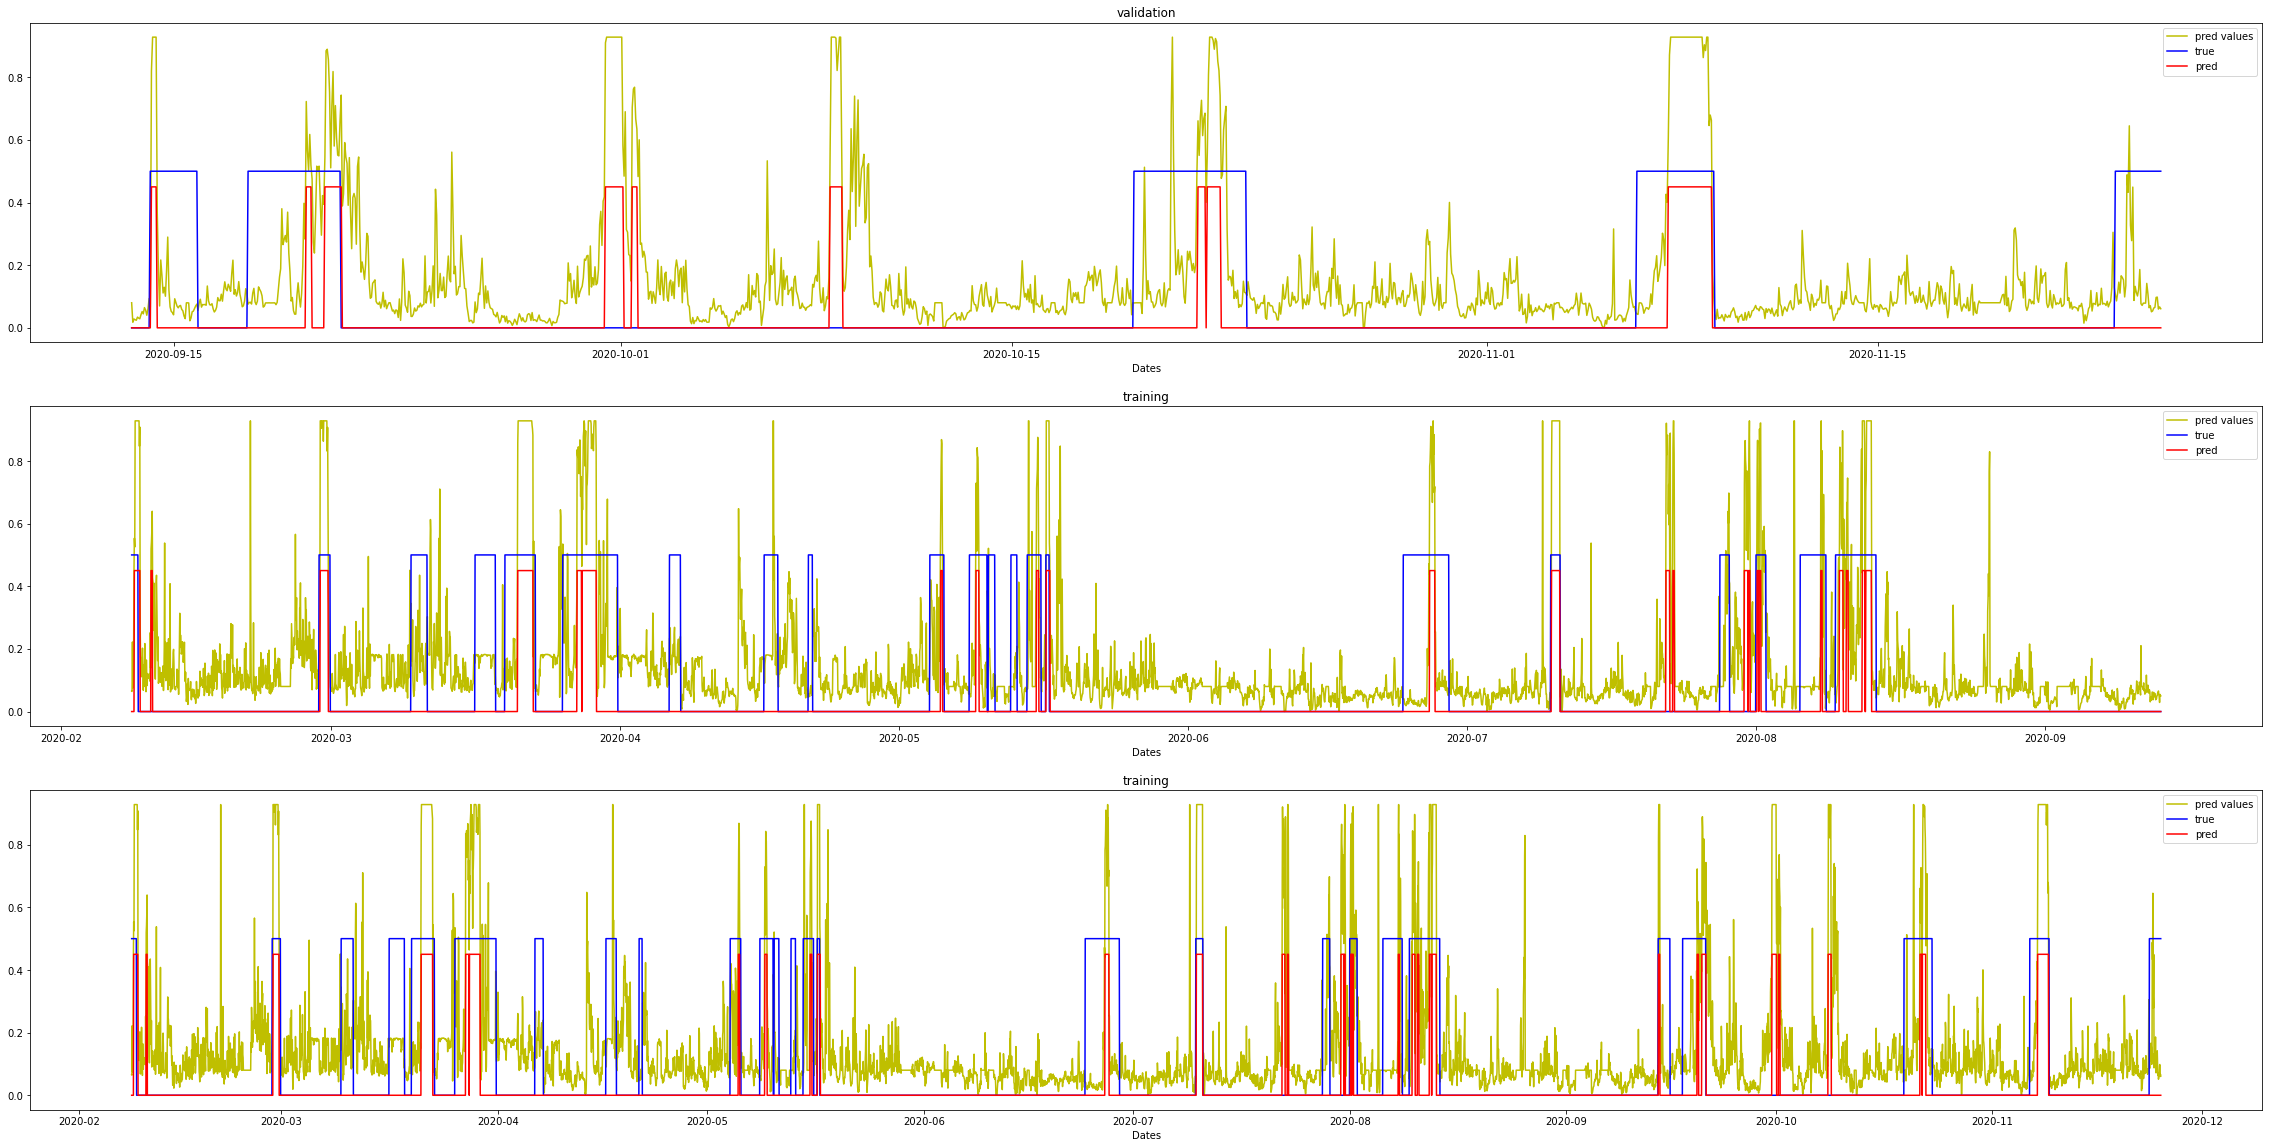

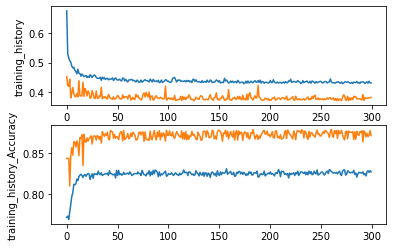

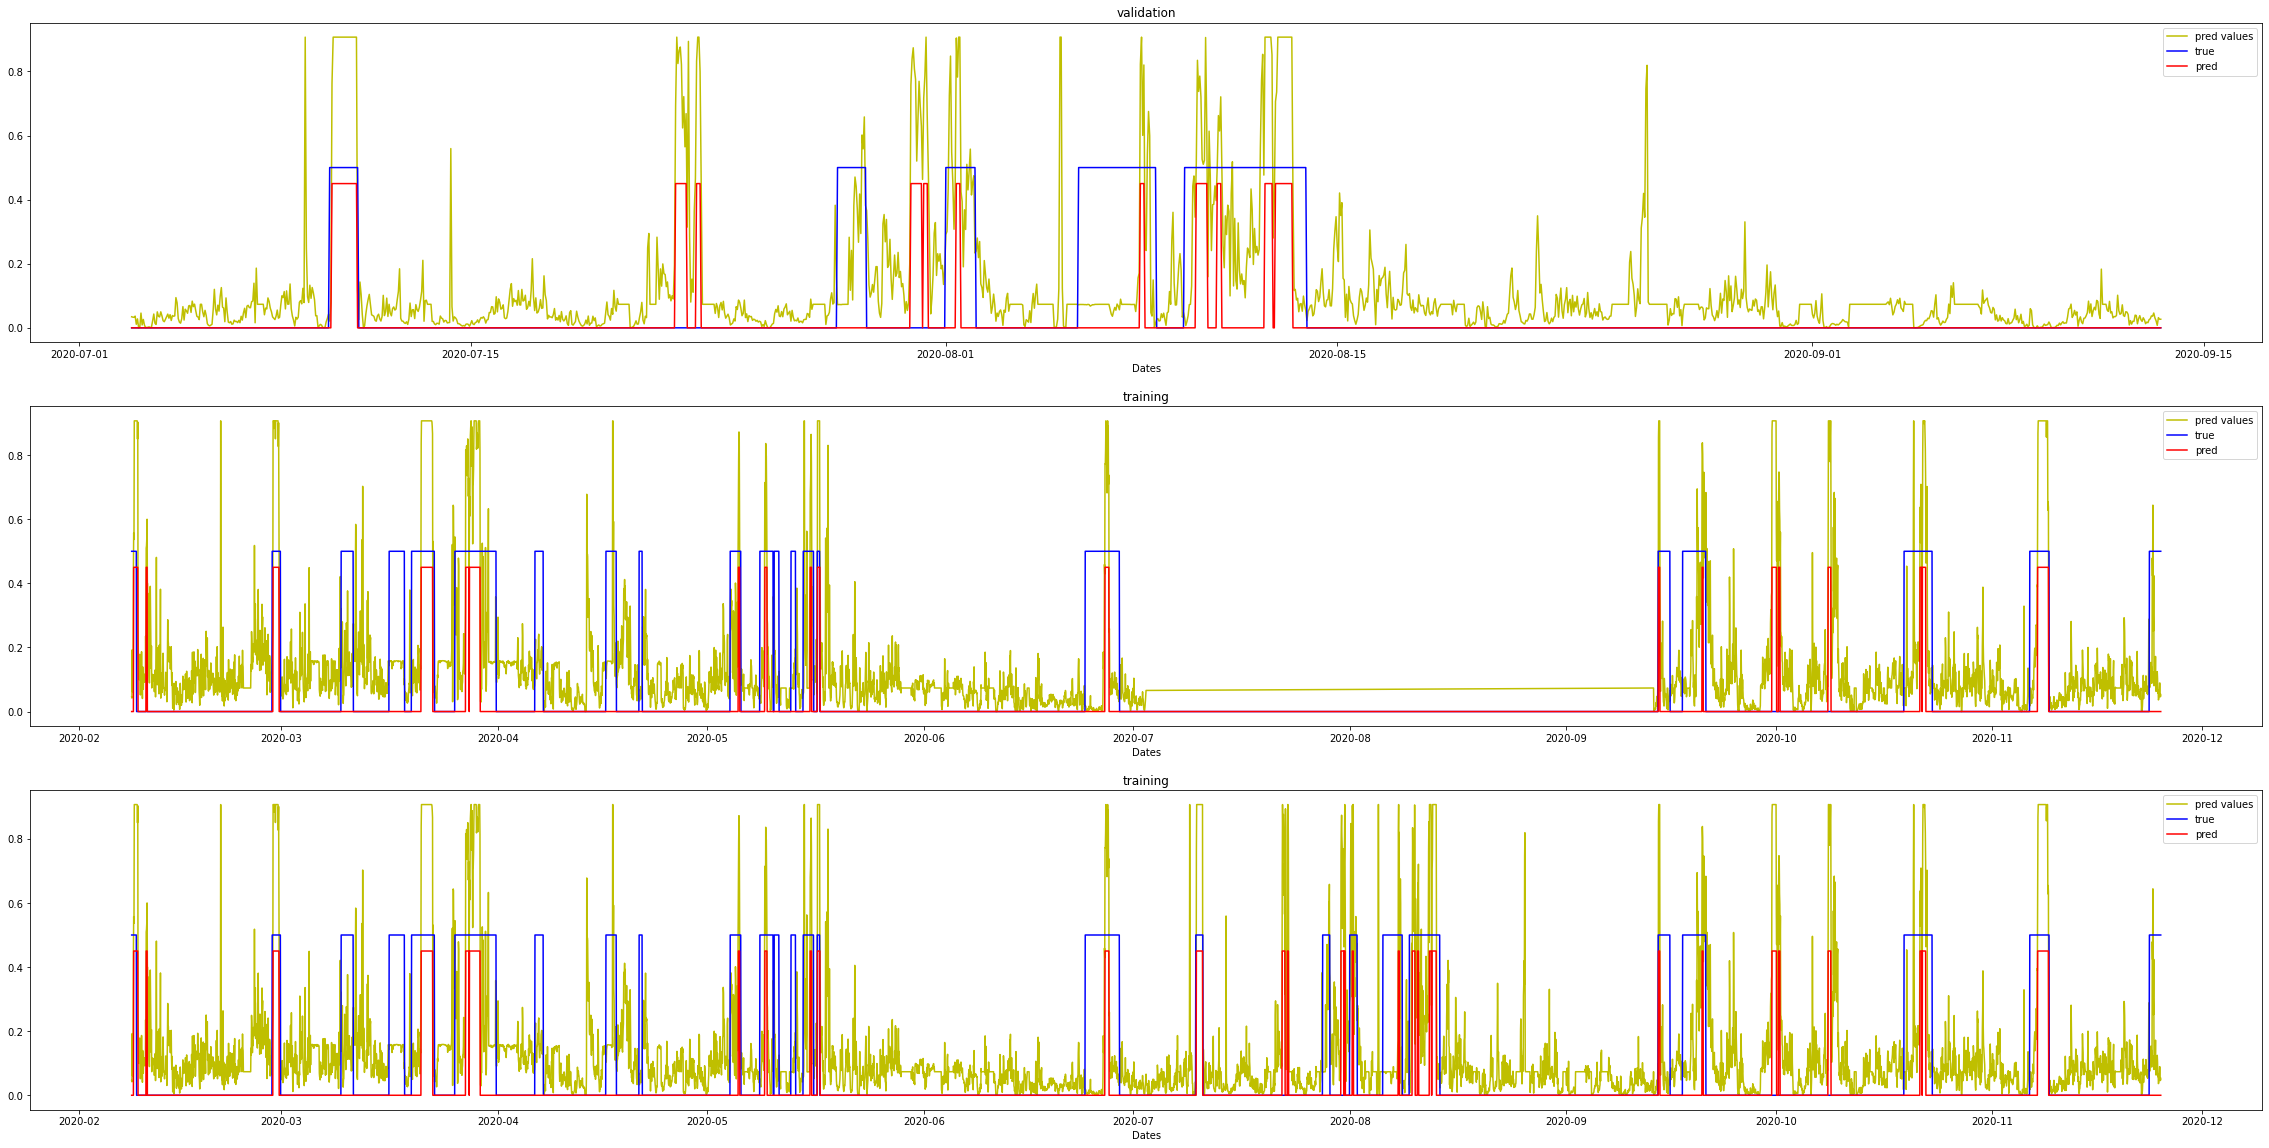

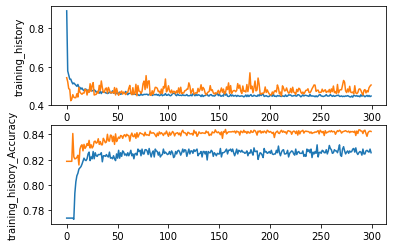

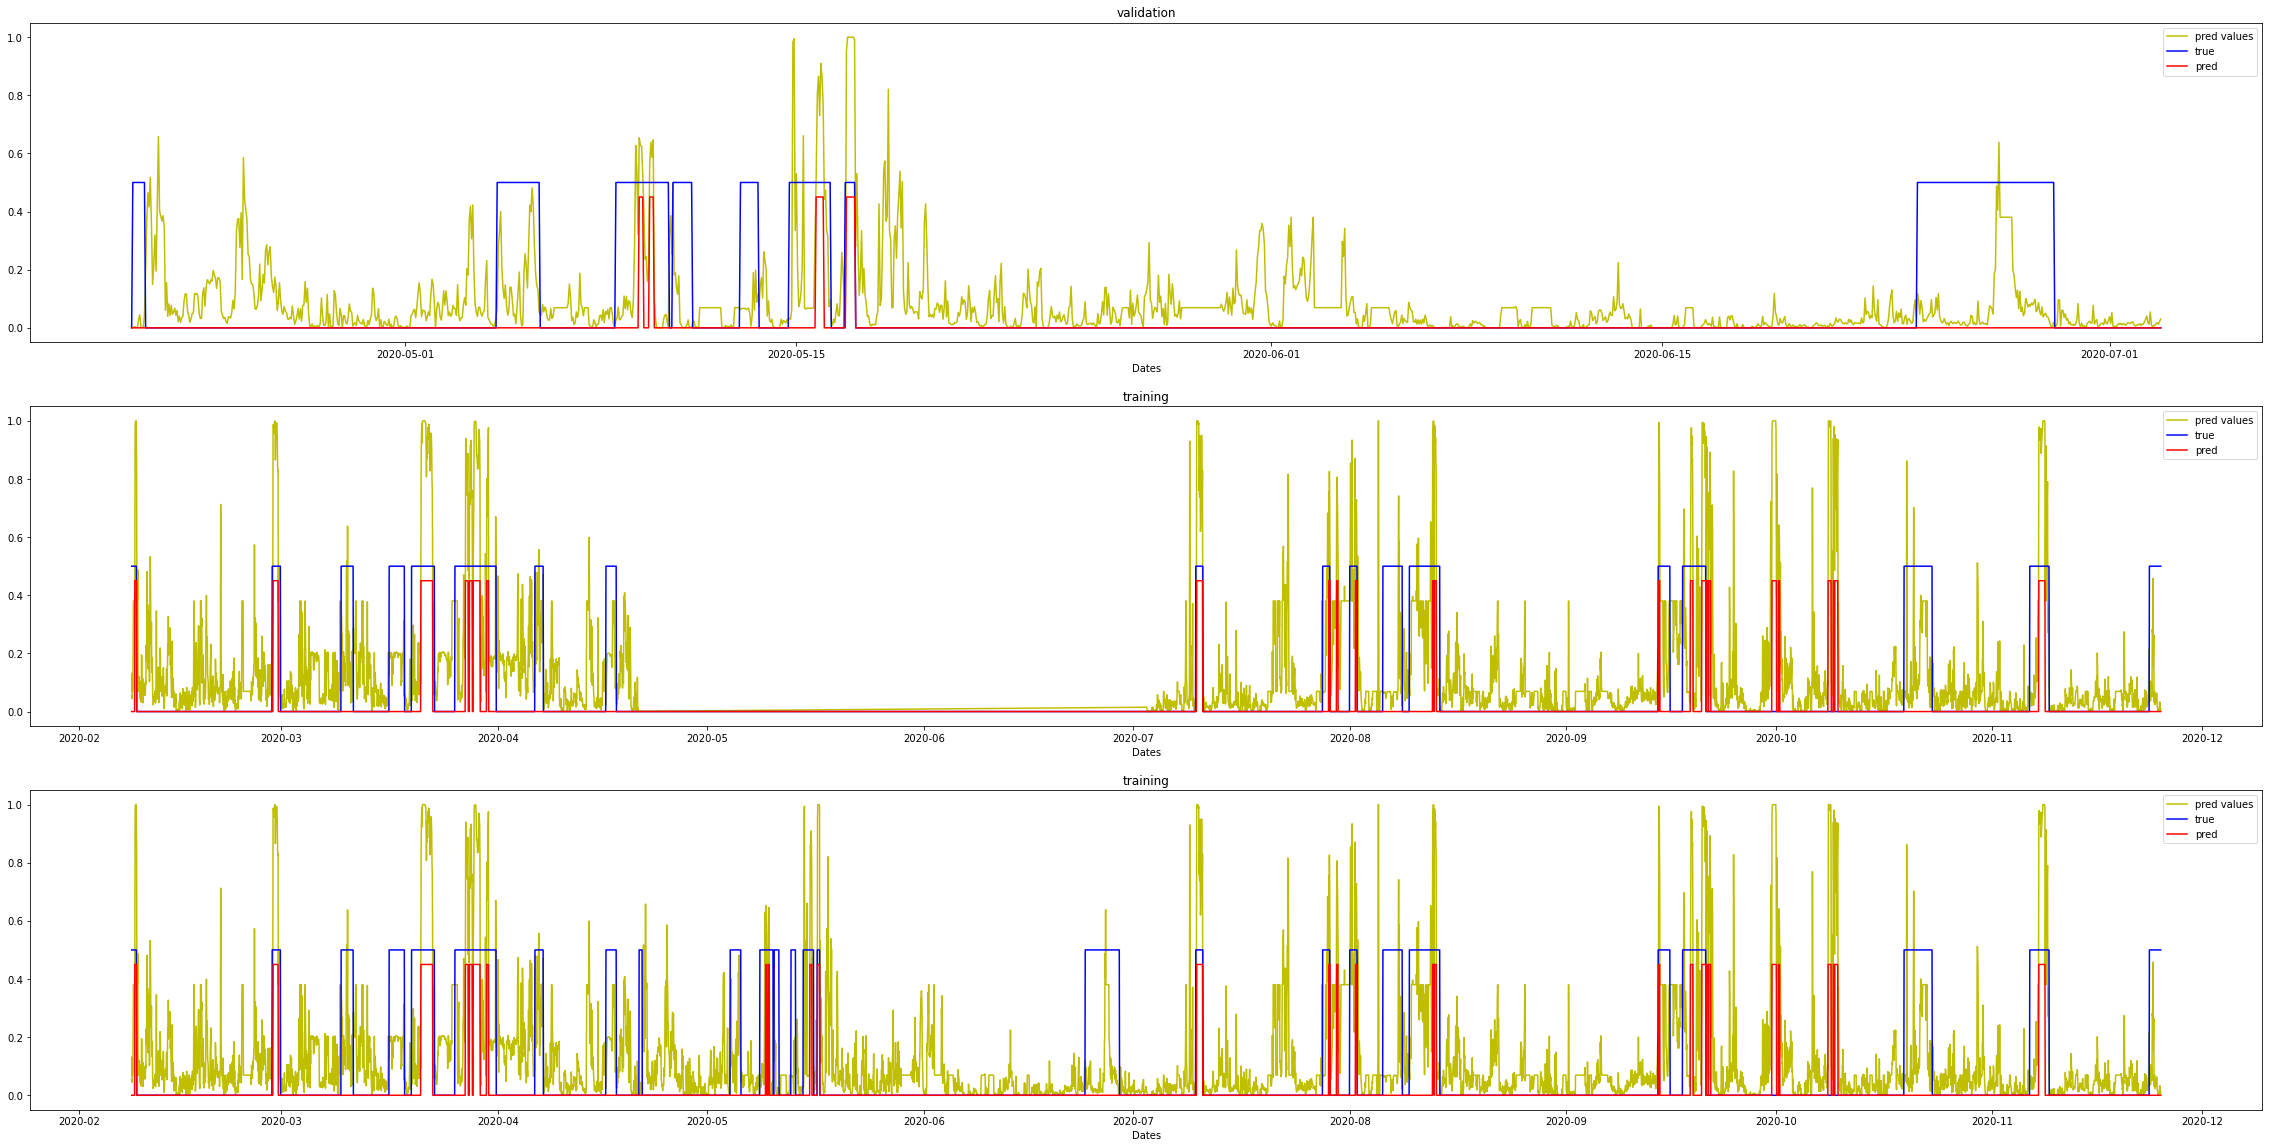

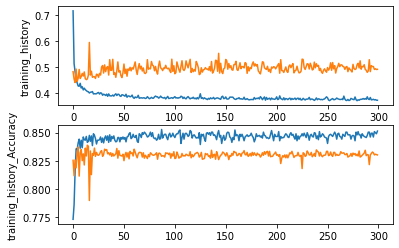

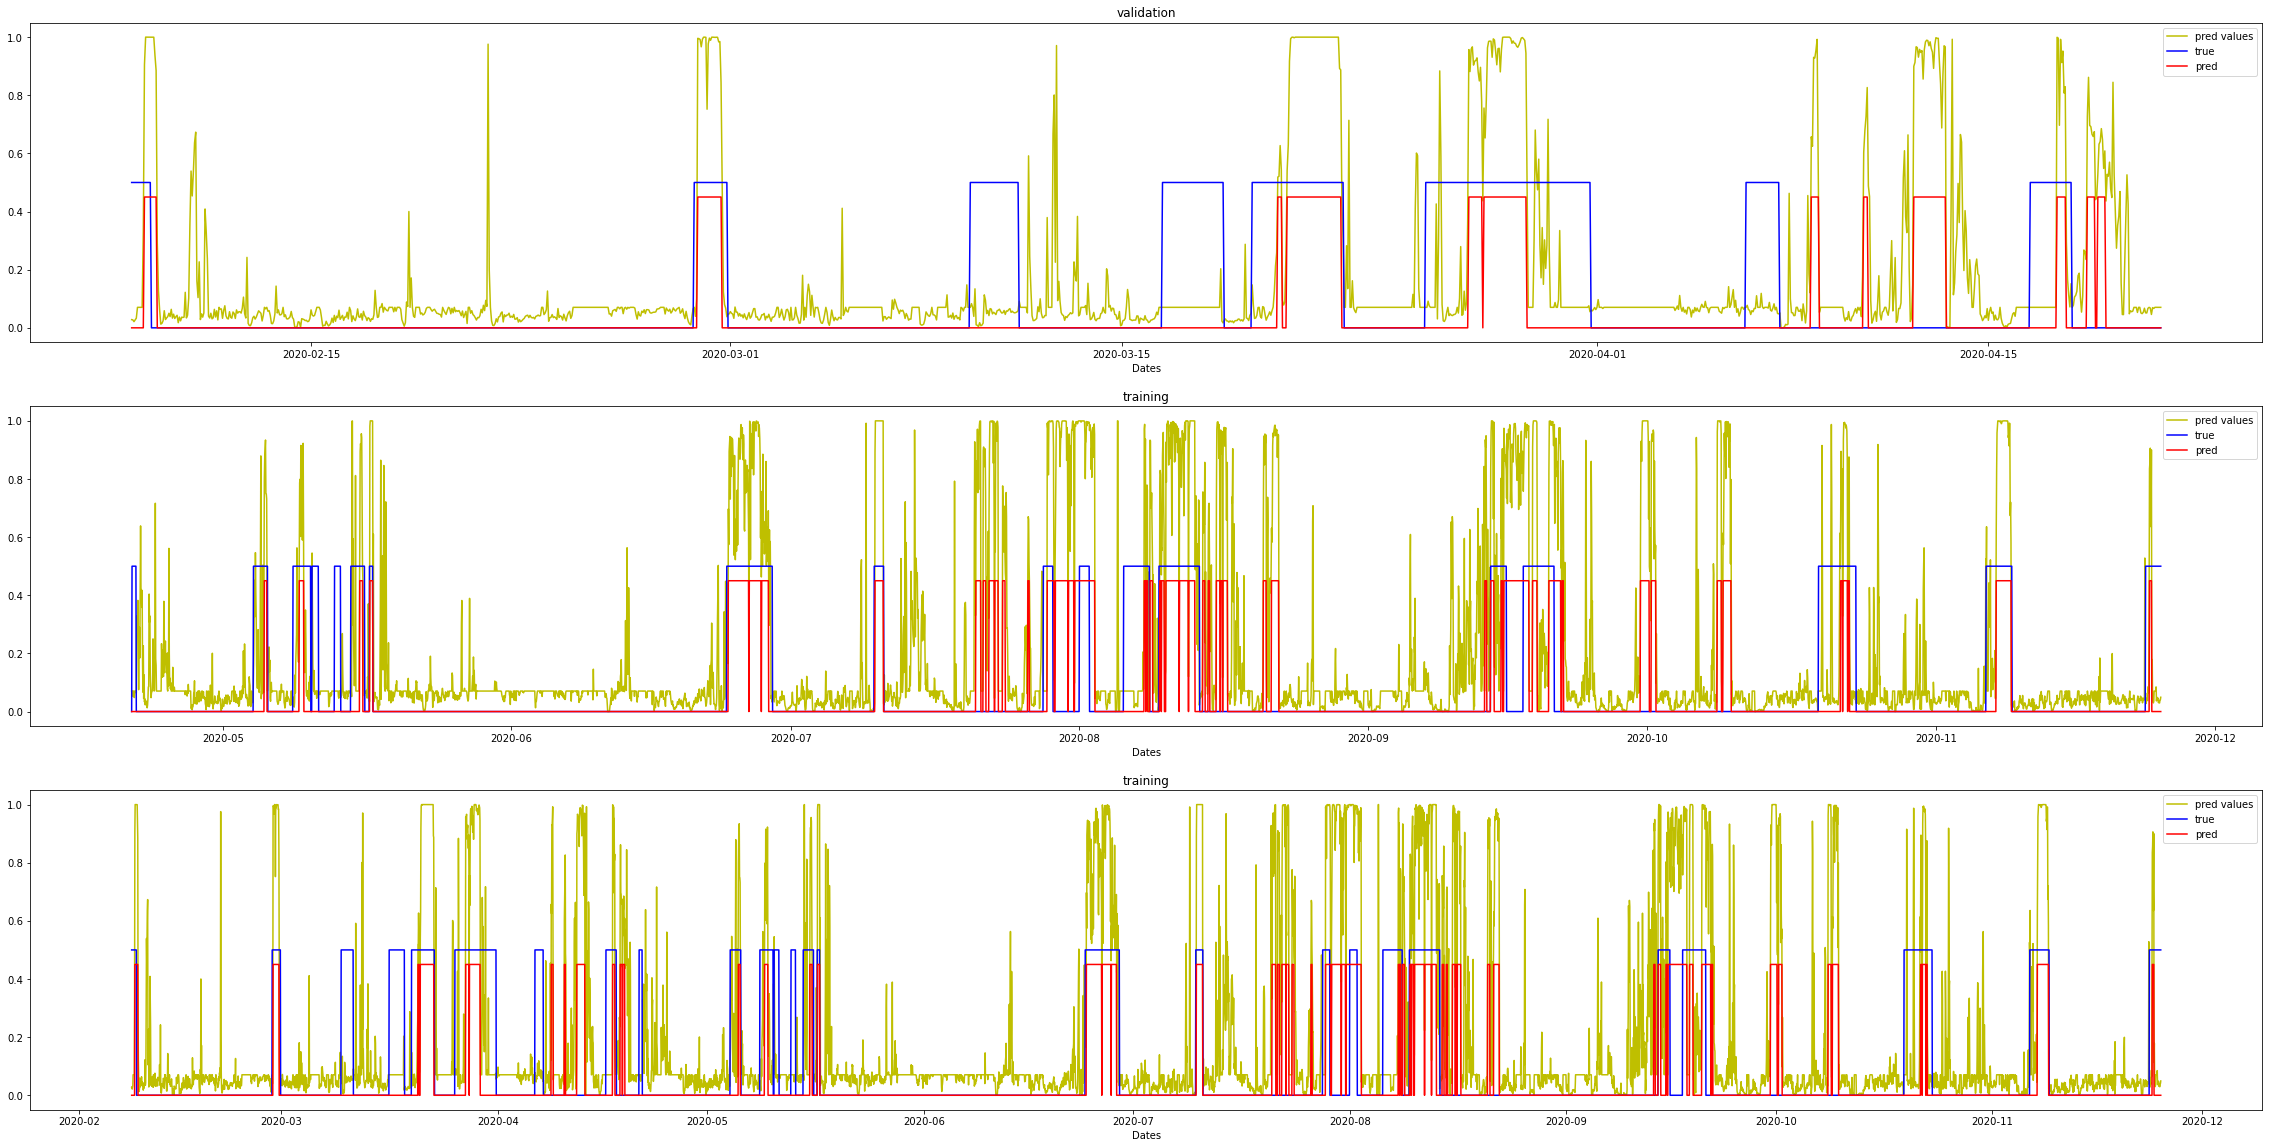

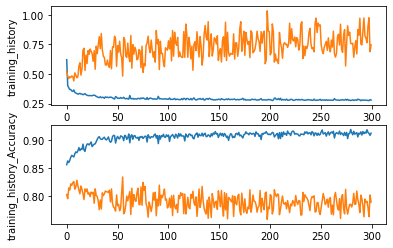

In [9]:


for index in [0,1,2,3]:
    
    print('Model: ', index)

    
    datafile_train = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/models_29_11_2022/train'+str(index)+'.h5'
    
    datafile_val = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/models_29_11_2022/val'+str(index)+'.h5'

    datafile = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/models_29_11_2022/data_all.h5'


    modelpath = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/models_06_12_2022/model1/model_'+str(index)

    
    
    df = pd.read_hdf(datafile, 'df') 
    df_output = df['sde_event']
    df_output = pd.DataFrame(data = df_output, columns = ['sde_event'])
    df_dates = df[['DateTimeUTC','sde_event','sde_event_nr']]
    df_input = df.drop(['sde_event_nr','sde_event','DateTimeUTC'],axis =1)

    df_input.reset_index(drop=True, inplace=True)

    df_output.reset_index(drop=True, inplace=True)

    df_dates.reset_index(drop=True, inplace=True)
    
    dvar_train = pd.read_hdf(datafile_train,key = 'dvar')
    dvar_val = pd.read_hdf(datafile_val,key = 'dvar')
    qoi_train = pd.read_hdf(datafile_train,key = 'qoi')
    qoi_val = pd.read_hdf(datafile_val,key = 'qoi')
    dates_train = pd.read_hdf(datafile_train,key = 'dates')
    dates_val = pd.read_hdf(datafile_val,key = 'dates')    
    history1=np.load(modelpath+'/my_history.npy',allow_pickle='TRUE').item()
    surr1 = keras.models.load_model(modelpath)
    # APPLY PREPROCESSING

    qoi_min = np.min(qoi_train, axis = 0)
    qoi_max = np.max(qoi_train, axis = 0)
    dvar_min = np.min(dvar_train, axis = 0)
    dvar_max = np.max(dvar_train, axis = 0)
    dvar_train_scaled = scaling(dvar_train, dvar_min, dvar_max, scale_min, scale_max)
    dvar_val_scaled = scaling(dvar_val, dvar_min, dvar_max, scale_min, scale_max)
    dvar_df_scaled = scaling(df_input, dvar_min, dvar_max, scale_min, scale_max)
    
    # USE TRAINED NETWORKS FOR PREDICTION
    qoi_val_pred = surr1.predict(np.asarray(dvar_val_scaled.values).astype('float32'))
    qoi_train_pred = surr1.predict(np.asarray(dvar_train_scaled.values).astype('float32'))
    qoi_df_pred = surr1.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
    
    qoi_val_pred = pd.DataFrame(qoi_val_pred, columns = ['sde_event'])
    qoi_train_pred = pd.DataFrame(qoi_train_pred, columns = ['sde_event'])
    
    qoi_df_pred = pd.DataFrame(qoi_df_pred, columns = ['sde_event'])
   
    qoi_train_pred = compute_dust_events(qoi_train_pred)
    qoi_val_pred = compute_dust_events(qoi_val_pred)
    qoi_df_pred = compute_dust_events(qoi_df_pred)
    
    dates_val = number_noevents_dates(dates_val, 'sde_event_nr', 'nosde_event_nr')
    dates_train = number_noevents_dates(dates_train, 'sde_event_nr', 'nosde_event_nr')
    df_dates = number_noevents_dates(df_dates, 'sde_event_nr', 'nosde_event_nr')
    qoi_val_pred = number_noevents_data(qoi_val_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')
    qoi_train_pred = number_noevents_data(qoi_train_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')
    qoi_df_pred = number_noevents_data(qoi_df_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

    
    
    print('Validation')
    result_val = metric_sde(dates_val, qoi_val_pred)
    print(result_val)
    result_val_acc = acc_prec_rec(result_val[4],result_val[5], result_val[6], result_val[7])
    
    print('Training')
    result_train = metric_sde(dates_train, qoi_train_pred)
    result_train_acc = acc_prec_rec(result_train[4],result_train[5], result_train[6], result_train[7])

    print('Whole dataframe')
    result_df = metric_sde(df_dates, qoi_df_pred)
    result_df_acc = acc_prec_rec(result_df[4],result_df[5], result_df[6], result_df[7])
    
    val_result = np.concatenate((result_val,np.array(result_val_acc[0:5])), axis =0)
    train_result = np.concatenate((result_train,np.array(result_train_acc[0:5])), axis =0)
    df_result = np.concatenate((result_df,np.array(result_df_acc[0:5])), axis =0)

    df_results['val_'+str(index)]= val_result
    df_results['train_'+str(index)] = train_result
    df_results['df_'+str(index)] = df_result
    df_results.rename(index = rowdict, inplace=True)
    df_results    
    
    
    
    
    
    # PLOT THE PREDICTIONS
    fig, axs = plt.subplots(3,1,figsize = (40,20))
    
    axs[0].plot(dates_val['Dates'],qoi_val_pred['sde_event'],'y',label='pred values')
    axs[0].plot(dates_val['Dates'],qoi_val['sde_event']*0.5,'b',label = 'true')

    axs[0].plot(dates_val['Dates'],(qoi_val_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    axs[0].set_xlabel('Dates')
    axs[0].set_title('validation')
    axs[0].legend()

    
    axs[1].plot(dates_train['Dates'],qoi_train_pred['sde_event'],'y',label='pred values')
    axs[1].plot(dates_train['Dates'],qoi_train['sde_event']*0.5,'b',label = 'true')

    axs[1].plot(dates_train['Dates'],(qoi_train_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    axs[1].set_title('training')
    axs[1].set_xlabel('Dates') 
    axs[1].legend()
    

    axs[2].plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred values')
    axs[2].plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

    axs[2].plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    axs[2].set_title('training')
    axs[2].set_xlabel('Dates')
    axs[2].legend()
    
    fig.savefig(f'{modelpath}/timeseries_pred.jpg')
    fig, axs = plt.subplots(2,1)
    axs[0].plot(history1['loss'])
    axs[0].plot(history1['val_loss'])
    axs[0].set_ylabel('training_history')

    axs[1].plot(history1['accuracy'])
    axs[1].plot(history1['val_accuracy'])
    axs[1].set_ylabel('training_history_Accuracy')
    fig.savefig(f'{modelpath}/history.jpg')

In [10]:
sde_df = qoi_df_pred.copy()
nosde_df = qoi_df_pred.copy()

In [11]:
df_dates

DateTimeUTC  sde_event  sde_event_nr  nosde_event_nr
0    2020-02-08 14:00:00        1.0           1.0               0
1    2020-02-08 15:00:00        1.0           1.0               0
2    2020-02-08 16:00:00        1.0           1.0               0
3    2020-02-08 17:00:00        1.0           1.0               0
4    2020-02-08 18:00:00        1.0           1.0               0
...                  ...        ...           ...             ...
6969 2020-11-24 23:00:00        1.0          26.0               0
6970 2020-11-25 00:00:00        1.0          26.0               0
6971 2020-11-25 01:00:00        1.0          26.0               0
6972 2020-11-25 02:00:00        1.0          26.0               0
6973 2020-11-25 03:00:00        1.0          26.0               0

[6974 rows x 4 columns]

In [12]:
sde_df['sde_event_predicted']=df_dates['sde_event']
sde_df['nosde_event_predicted_nr']=df_dates['sde_event_nr']
sde_df['sde_event_predicted_nr']=df_dates['nosde_event_nr']

nosde_df['sde_event_predicted']=df_dates['sde_event']+1
nosde_df['sde_event_predicted'][nosde_df['sde_event_predicted']==2]=0

nosde_df['nosde_event_predicted_nr']=df_dates['nosde_event_nr']
nosde_df['sde_event_predicted_nr']=df_dates['sde_event_nr']


/tmp/ipykernel_11777/137104283.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nosde_df['sde_event_predicted'][nosde_df['sde_event_predicted']==2]=0


In [13]:
nosde_df

sde_event  sde_event_predicted  nosde_event_predicted_nr  \
0      0.028194                  0.0                         0   
1      0.027338                  0.0                         0   
2      0.021284                  0.0                         0   
3      0.027321                  0.0                         0   
4      0.033258                  0.0                         0   
...         ...                  ...                       ...   
6969   0.029513                  0.0                         0   
6970   0.029648                  0.0                         0   
6971   0.039737                  0.0                         0   
6972   0.040210                  0.0                         0   
6973   0.049187                  0.0                         0   

      sde_event_predicted_nr  
0                        1.0  
1                        1.0  
2                        1.0  
3                        1.0  
4                        1.0  
...                      ...  
6969                    26.0  
6970                    26.0  
6971                    26.0  
6972                    26.0  
6973                    26.0  

[6974 rows x 4 columns]

In [14]:
sde_df

sde_event  sde_event_predicted  nosde_event_predicted_nr  \
0      0.028194                  1.0                       1.0   
1      0.027338                  1.0                       1.0   
2      0.021284                  1.0                       1.0   
3      0.027321                  1.0                       1.0   
4      0.033258                  1.0                       1.0   
...         ...                  ...                       ...   
6969   0.029513                  1.0                      26.0   
6970   0.029648                  1.0                      26.0   
6971   0.039737                  1.0                      26.0   
6972   0.040210                  1.0                      26.0   
6973   0.049187                  1.0                      26.0   

      sde_event_predicted_nr  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  
...                      ...  
6969                       0  
6970                       0  
6971                       0  
6972                       0  
6973                       0  

[6974 rows x 4 columns]

In [15]:
result_train1 = metric_sde(df_dates, sde_df)
result_train_acc1 = acc_prec_rec(result_train1[4],result_train1[5], result_train1[6], result_train1[7])


True positive:  26
False negative:  0
True negative:  25
False positive:  0
TP 26
FP 0
accuracy:  1.0
precision:  1.0
sensitivity (recall):  1.0
specificity:  1.0
F1:  1.0


In [16]:
result_train2 = metric_sde(df_dates, nosde_df)
result_train_acc2 = acc_prec_rec(result_train2[4],result_train2[5], result_train2[6], result_train2[7])

True positive:  0
False negative:  26
True negative:  0
False positive:  25
TP 0
FP 25
accuracy:  0.0
precision:  0.0
sensitivity (recall):  0.0
specificity:  0.0
F1:  0


In [17]:
qoi_df_pred

sde_event  sde_event_predicted  nosde_event_predicted_nr  \
0      0.028194                  0.0                         1   
1      0.027338                  0.0                         1   
2      0.021284                  0.0                         1   
3      0.027321                  0.0                         1   
4      0.033258                  0.0                         1   
...         ...                  ...                       ...   
6969   0.029513                  0.0                        62   
6970   0.029648                  0.0                        62   
6971   0.039737                  0.0                        62   
6972   0.040210                  0.0                        62   
6973   0.049187                  0.0                        62   

      sde_event_predicted_nr  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  
...                      ...  
6969                       0  
6970                       0  
6971                       0  
6972                       0  
6973                       0  

[6974 rows x 4 columns]

In [18]:
result_train3 = metric_sde(df_dates, qoi_df_pred)
result_train_acc3 = acc_prec_rec(result_train3[4],result_train3[5], result_train3[6], result_train3[7])


True positive:  20
False negative:  6
True negative:  15
False positive:  10
TP 20
FP 10
accuracy:  0.6862745098039216
precision:  0.6666666666666666
sensitivity (recall):  0.7692307692307693
specificity:  0.6
F1:  0.7142857142857142


In [19]:
qoi_df_pred


sde_event  sde_event_predicted  nosde_event_predicted_nr  \
0      0.028194                  0.0                         1   
1      0.027338                  0.0                         1   
2      0.021284                  0.0                         1   
3      0.027321                  0.0                         1   
4      0.033258                  0.0                         1   
...         ...                  ...                       ...   
6969   0.029513                  0.0                        62   
6970   0.029648                  0.0                        62   
6971   0.039737                  0.0                        62   
6972   0.040210                  0.0                        62   
6973   0.049187                  0.0                        62   

      sde_event_predicted_nr  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  
...                      ...  
6969                       0  
6970                       0  
6971                       0  
6972                       0  
6973                       0  

[6974 rows x 4 columns]

In [20]:
qoi_df_pred[qoi_df_pred['nosde_event_predicted_nr']!=0]

sde_event  sde_event_predicted  nosde_event_predicted_nr  \
0      0.028194                  0.0                         1   
1      0.027338                  0.0                         1   
2      0.021284                  0.0                         1   
3      0.027321                  0.0                         1   
4      0.033258                  0.0                         1   
...         ...                  ...                       ...   
6969   0.029513                  0.0                        62   
6970   0.029648                  0.0                        62   
6971   0.039737                  0.0                        62   
6972   0.040210                  0.0                        62   
6973   0.049187                  0.0                        62   

      sde_event_predicted_nr  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  
...                      ...  
6969                       0  
6970                       0  
6971                       0  
6972                       0  
6973                       0  

[6025 rows x 4 columns]

In [21]:
qoi_df_pred[qoi_df_pred['sde_event_predicted_nr']!=0]

sde_event  sde_event_predicted  nosde_event_predicted_nr  \
11     0.905458                  1.0                         0   
12     0.999998                  1.0                         0   
13     1.000000                  1.0                         0   
14     1.000000                  1.0                         0   
15     1.000000                  1.0                         0   
...         ...                  ...                       ...   
6945   0.856102                  1.0                         0   
6946   0.906053                  1.0                         0   
6947   0.729587                  1.0                         0   
6948   0.635617                  1.0                         0   
6949   0.900189                  1.0                         0   

      sde_event_predicted_nr  
11                         1  
12                         1  
13                         1  
14                         1  
15                         1  
...                      ...  
6945                      61  
6946                      61  
6947                      61  
6948                      61  
6949                      61  

[949 rows x 4 columns]

In [22]:
len(qoi_df_pred)

6974

In [26]:
#qoi_df_pred['sde_event'] & qoi_df_pred['sde_event_predicted']
def sde_statistics(qoi_df_pred):
# total amount of hours of dust events: 
    tot_nr_sde = qoi_df_pred[qoi_df_pred['sde_event_predicted']==1]['sde_event_predicted'].size

    print("hours of dust events: ",tot_nr_sde)
# total amount of hours of no dust event:
    tot_nr_nosde = qoi_df_pred[qoi_df_pred['sde_event_predicted']==0]['sde_event_predicted'].size
    print("hours with no dust events:",tot_nr_nosde)

    print("percentage of dust events [%]:",tot_nr_sde/tot_nr_nosde*100)

    #if len(qoi_df_pred)== 6974:
        





In [27]:
print('prediction')
sde_statistics(qoi_df_pred)
print('false')
sde_statistics(nosde_df)
print('true')
sde_statistics(sde_df)


prediction
hours of dust events:  949
hours with no dust events: 6025
percentage of dust events [%]: 15.751037344398341
false
hours of dust events:  5684
hours with no dust events: 1290
percentage of dust events [%]: 440.6201550387597
true
hours of dust events:  1290
hours with no dust events: 5684
percentage of dust events [%]: 22.695285010555946


In [28]:
qoi_val_pred[nosde_event_predicted_nr]

# within a dust event count the number of predicted events

# give the duration of the dust event and the predicted hours

# give the duration of no dust event detected in this time


# how many additional dust events are detected


NameError: name 'nosde_event_predicted_nr' is not defined

In [29]:
def metric_sde(dates, qoi_val_pred):
    count_sde = 0
    count_nosde = 0
    dust_event_nrs = dates['sde_event_nr'].unique()[0:]
    #print(dust_event_nrs)
    dust_event_nrs = np.delete(dust_event_nrs,  np.where(dust_event_nrs == 0))
    #print(dust_event_nrs)
    nodust_event_nrs = dates['nosde_event_nr'].unique()[0:]
    nodust_event_nrs = np.delete(nodust_event_nrs,  np.where(nodust_event_nrs == 0))
    
    for ev in (dust_event_nrs):
        #print('dust_event_number: ',ev)
        ev_index = dates[dates['sde_event_nr']==ev].index
        print('****')
        print('dates index')
        print(ev_index.size)
        #print(qoi_val_pred['sde_event_predicted'].loc[ev_index].sum())
        if qoi_val_pred['sde_event_predicted'].loc[ev_index].sum() >0:
            
            np.where(qoi_val_pred['sde_event_predicted'].loc[ev_index]==1)
            
            
            
            plt.figure()
            plt.plot(df_dates['DateTimeUTC'].loc[ev_index],df_dates['sde_event'].loc[ev_index])

            plt.plot(df_dates['DateTimeUTC'].loc[ev_index],qoi_val_pred['sde_event_predicted'].loc[ev_index])
            print('sum of predictions')
            print(qoi_val_pred['sde_event_predicted'].loc[ev_index].sum())
            count_sde = count_sde+1
            #print('count_sde',count_sde)

    for noev in (nodust_event_nrs):
        #print('nodust_event_number: ',noev)
        noev_index = dates[dates['nosde_event_nr']==noev].index
        #print(qoi_val_pred['sde_event_predicted'].loc[noev_index].sum())
        if qoi_val_pred['sde_event_predicted'].loc[noev_index].sum() >0:
            
            count_nosde = count_nosde
         #   print('**if',count_nosde)
        else:
            
            count_nosde = count_nosde +1
          #  print('**else',count_nosde)
    N_sde_truth = len(dust_event_nrs) 
    N_nosde_truth = len(nodust_event_nrs)
    TP = count_sde
    FN = N_sde_truth - TP
    TN = count_nosde
    FP = N_nosde_truth - count_nosde
    N_sde_pred = qoi_val_pred['sde_event_predicted_nr'].max()
    N_nosde_pred = qoi_val_pred['nosde_event_predicted_nr'].max()

   # print('true number sde: ', N_sde_truth )
   # print('true number nosde: ', N_nosde_truth)
   # print('predicted number sde: ',N_sde_pred )
    
   # print('predicted number nosde: ', N_nosde_pred)
    print('True positive: ', TP)
    print('False negative: ',FN)
    print('True negative: ', TN)
    print('False positive: ',FP)

    result = [N_sde_truth, N_nosde_truth, N_sde_pred, N_nosde_pred, TP, FN, TN, FP]
    
    return result


In [30]:
ev_index = df_dates[df_dates['sde_event_nr']==2].index
ev_index

Int64Index([483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495,
            496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508,
            509, 510, 511],
           dtype='int64')

In [31]:
test_ind = np.where(qoi_val_pred['sde_event_predicted'].loc[ev_index]==1)
test_ind

(array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23]),)

In [32]:
ev_index_pred =ev_index[test_ind]
ev_index_pred

Int64Index([486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
            499, 500, 501, 502, 503, 504, 505, 506],
           dtype='int64')

In [33]:
df_dates

DateTimeUTC  sde_event  sde_event_nr  nosde_event_nr
0    2020-02-08 14:00:00        1.0           1.0               0
1    2020-02-08 15:00:00        1.0           1.0               0
2    2020-02-08 16:00:00        1.0           1.0               0
3    2020-02-08 17:00:00        1.0           1.0               0
4    2020-02-08 18:00:00        1.0           1.0               0
...                  ...        ...           ...             ...
6969 2020-11-24 23:00:00        1.0          26.0               0
6970 2020-11-25 00:00:00        1.0          26.0               0
6971 2020-11-25 01:00:00        1.0          26.0               0
6972 2020-11-25 02:00:00        1.0          26.0               0
6973 2020-11-25 03:00:00        1.0          26.0               0

[6974 rows x 4 columns]

In [34]:
if ev_index_pred[0]==ev_index[0]:
    #find the last 0 before the predicted sde starts
    #create an array with indices between 0 and the predicted sde starts
    test_start_array1 = np.arange(0,ev_index_pred[0])
    test_start_array2 = np.where(qoi_val_pred['sde_event_predicted'].loc[test_start_array1]==0)
    sde_start_hours = test_start_array2[-1]
    
else: 
    sde_start_hours = ev_index_pred[0]
if ev_index_pred[-1]==ev_index[-1]:
    # find the first 0 after the end of predicted sde
    test_end_array1 = np.arange(ev_index_pred[-1],6974)
    test_end_array2 = np.where(qoi_val_pred['sde_event_predicted'].loc[test_end_array2]==0)
    sde_start_hours = test_end_array2[0]+test_end_array1[0]
else:
    sde_end_hours = ev_index_pred[-1]
    
    

****
dates index
17
sum of predictions
17.0
****
dates index
29
sum of predictions
29.0
****
dates index
42
sum of predictions
42.0
****
dates index
53
sum of predictions
53.0
****
dates index
79
sum of predictions
79.0
****
dates index
142
sum of predictions
142.0
****
dates index
29
sum of predictions
29.0
****
dates index
36
sum of predictions
36.0
****
dates index
11
sum of predictions
11.0
****
dates index
37
sum of predictions
37.0
****
dates index
46
sum of predictions
46.0
****
dates index
17
sum of predictions
17.0
****
dates index
16
sum of predictions
16.0
****
dates index
36
sum of predictions
36.0
****
dates index
9
sum of predictions
9.0
****
dates index
118
sum of predictions
118.0
****
dates index
25
sum of predictions
25.0
****
dates index
25
sum of predictions
25.0
****
dates index
26
sum of predictions
26.0
****
dates index
67
sum of predictions
67.0
****
dates index
105
sum of predictions
105.0
****
dates index
41
sum of predictions
41.0
****
dates index
80


/tmp/ipykernel_11777/792345811.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


sum of predictions
80.0
****
dates index
97
sum of predictions
97.0
****
dates index
67
sum of predictions
67.0
****
dates index
40
sum of predictions
40.0
True positive:  26
False negative:  0
True negative:  25
False positive:  0


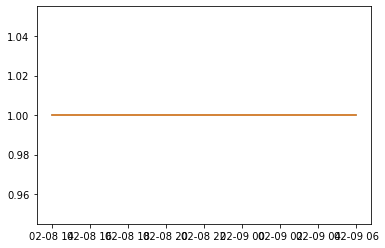

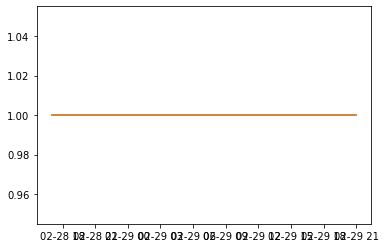

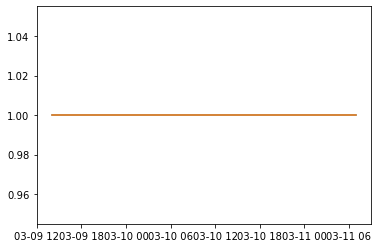

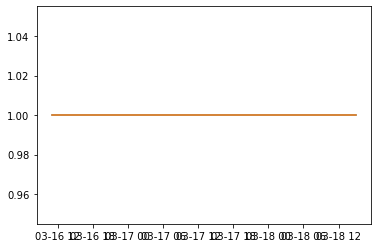

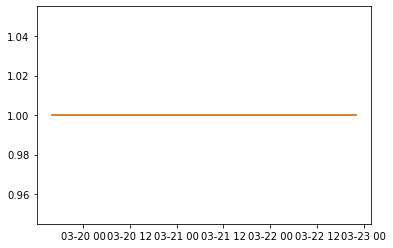

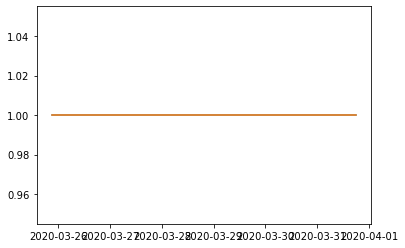

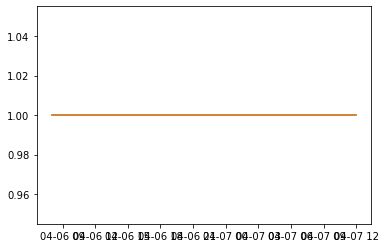

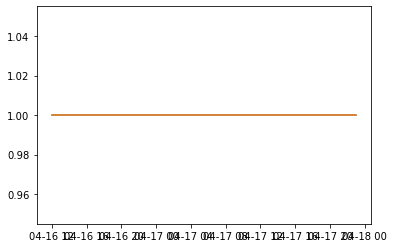

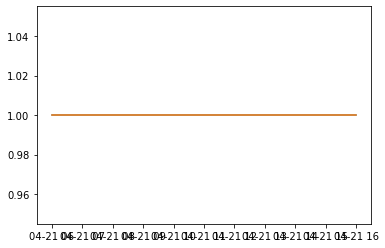

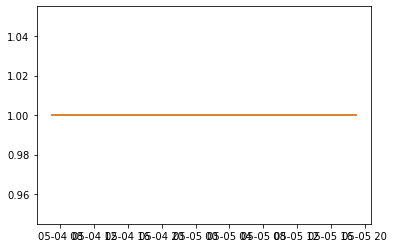

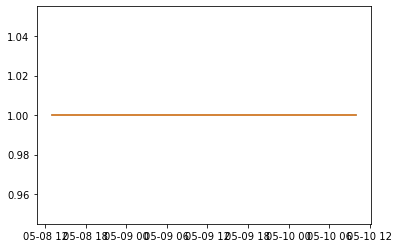

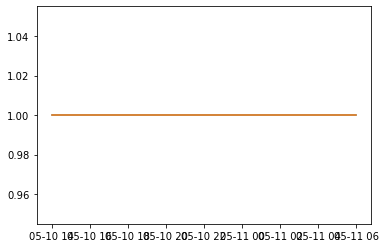

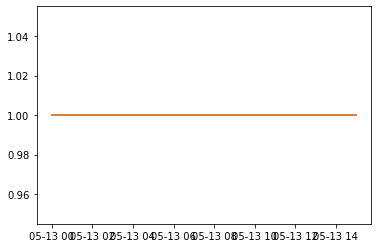

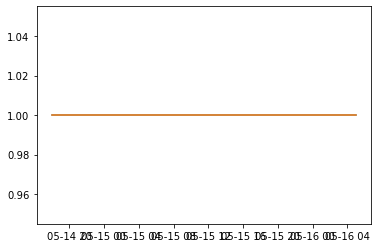

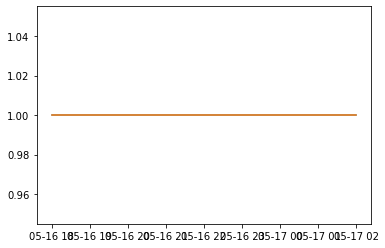

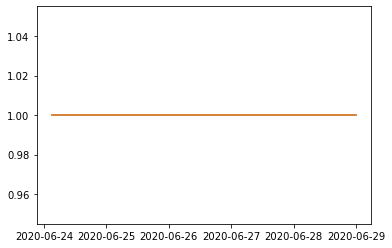

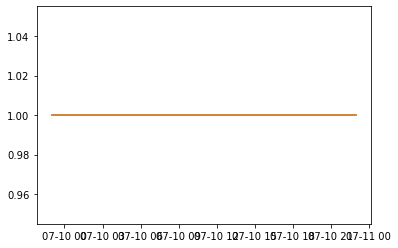

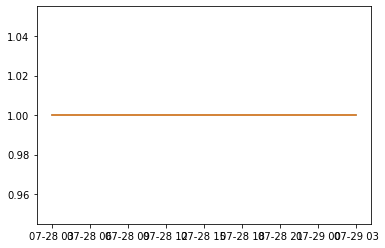

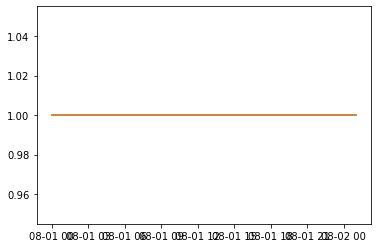

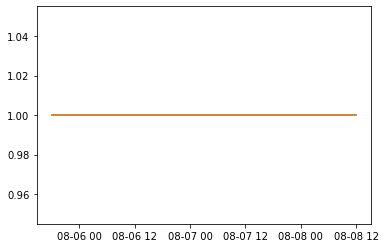

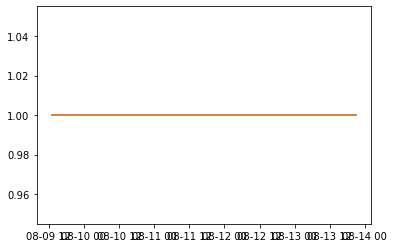

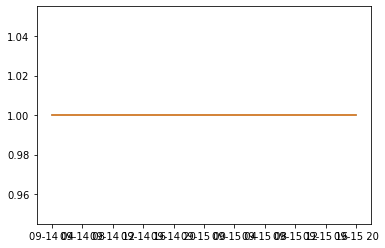

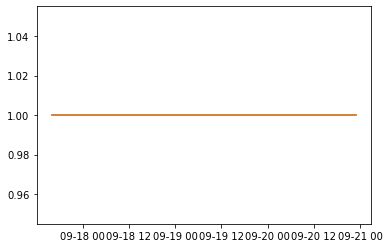

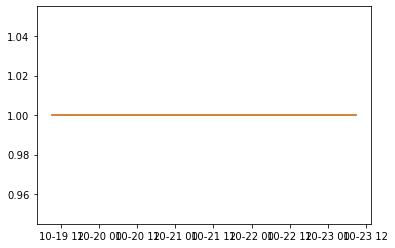

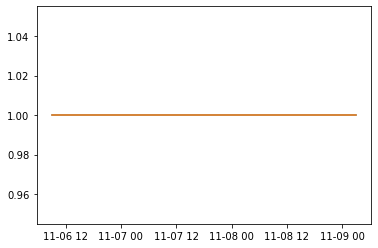

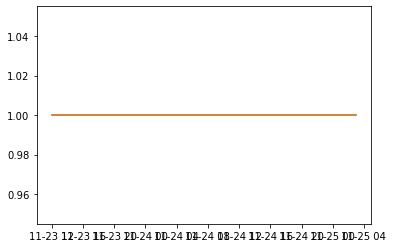

In [35]:
result_train1 = metric_sde(df_dates, sde_df)


****
dates index
17
sum of predictions
6.0
****
dates index
29
sum of predictions
21.0
****
dates index
42
****
dates index
53
****
dates index
79
sum of predictions
51.0
****
dates index
142
sum of predictions
49.0
****
dates index
29
****
dates index
36
sum of predictions
8.0
****
dates index
11
****
dates index
37
sum of predictions
7.0
****
dates index
46
sum of predictions
12.0
****
dates index
17
****
dates index
16
****
dates index
36
sum of predictions
8.0
****
dates index
9
sum of predictions
8.0
****
dates index
118
sum of predictions
102.0
****
dates index
25
sum of predictions
22.0
****
dates index
25
sum of predictions
15.0
****
dates index
26
sum of predictions
26.0
****
dates index
67
sum of predictions
8.0
****
dates index
105
sum of predictions
84.0
****
dates index
41
sum of predictions
20.0
****
dates index
80
sum of predictions
41.0
****
dates index
97
sum of predictions
21.0
****
dates index
67
sum of predictions
39.0
****
dates index
40
sum of predictions
6.0
True

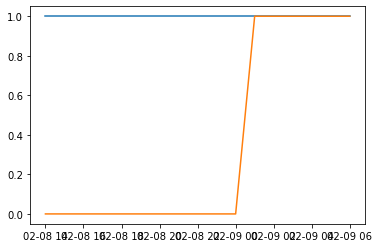

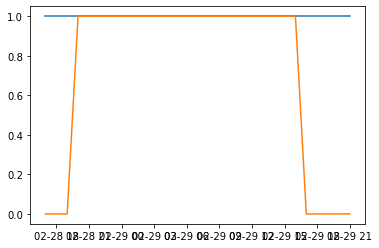

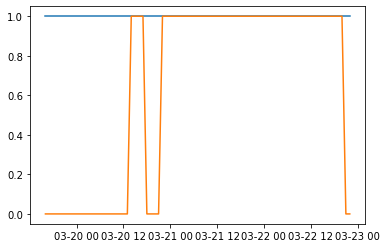

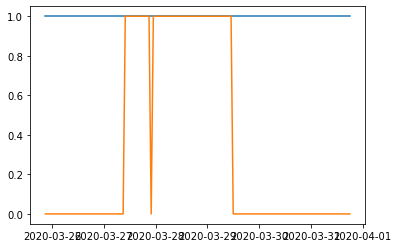

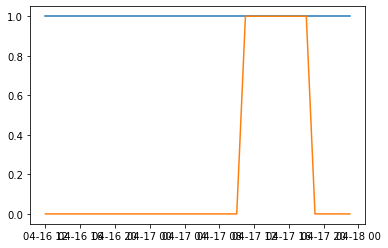

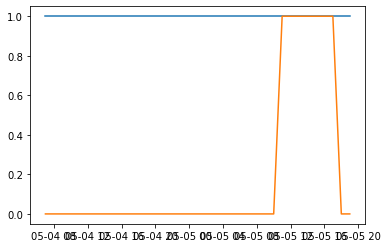

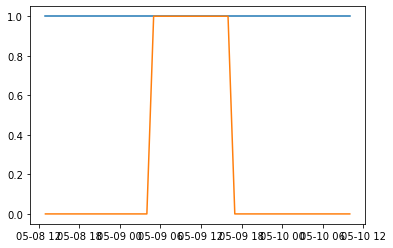

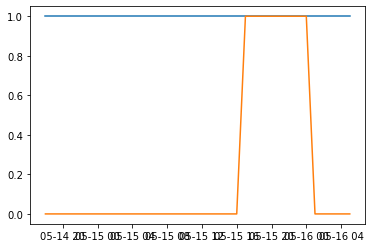

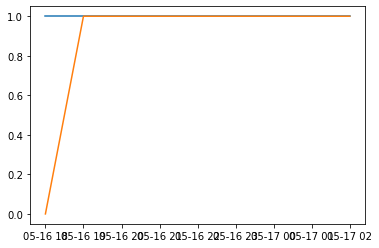

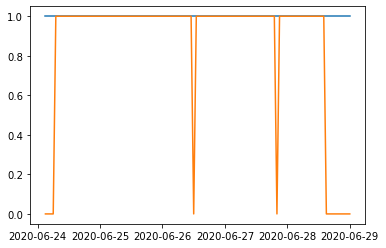

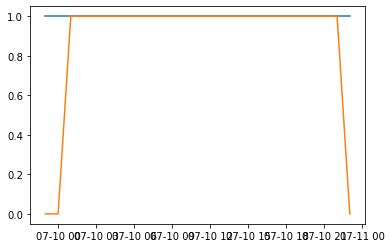

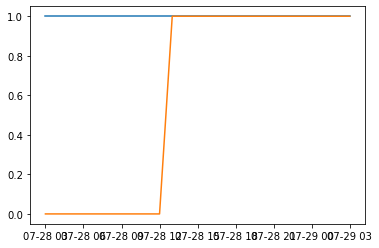

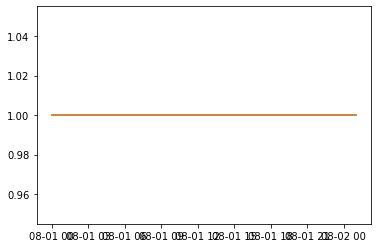

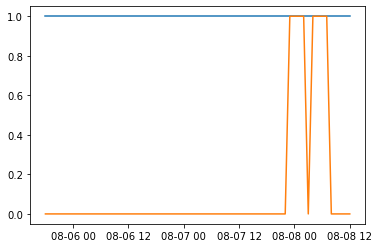

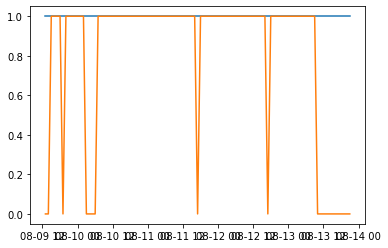

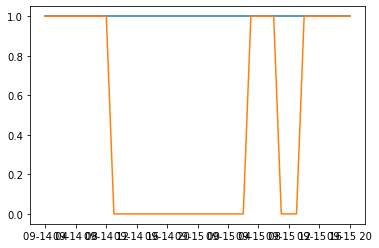

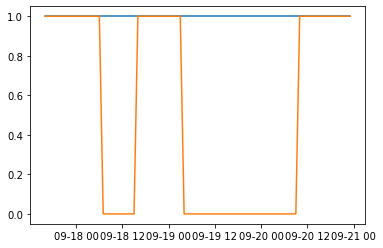

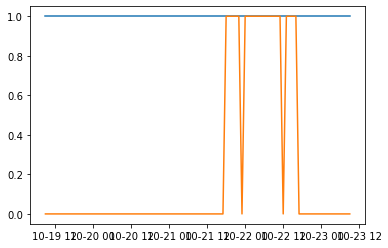

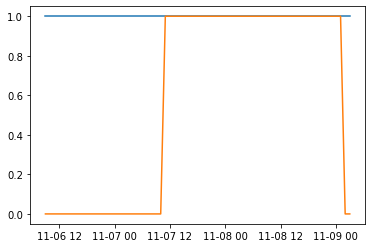

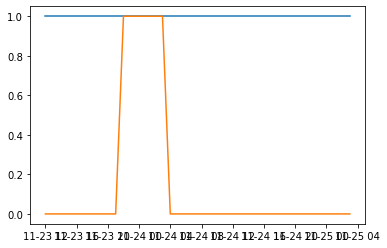

In [36]:
result_train3 = metric_sde(df_dates, qoi_df_pred)

In [37]:
# determine length of each dust event within the true dust event: all gaps in between are ignored:
# search for first index, where there is a 1, search for last index of 1
# if the first index is equal to the start of the dust event, search for the last 0 before
# if the last index is equal to the end of the dust event, search for the first 0 after



In [38]:
qoi_train_pred.describe()

sde_event  sde_event_predicted  nosde_event_predicted_nr  \
count  5.231000e+03          5231.000000               5231.000000   
mean   2.031859e-01             0.144523                 20.134773   
std    3.078207e-01             0.351653                 19.035059   
min    1.947029e-08             0.000000                  0.000000   
25%    3.654223e-02             0.000000                  3.000000   
50%    7.048969e-02             0.000000                  9.000000   
75%    1.386423e-01             0.000000                 41.000000   
max    1.000000e+00             1.000000                 50.000000   

       sde_event_predicted_nr  
count             5231.000000  
mean                 3.549990  
std                 10.234709  
min                  0.000000  
25%                  0.000000  
50%                  0.000000  
75%                  0.000000  
max                 49.000000

In [39]:
qoi_df_pred['Ssde'] = 0*qoi_df_pred['sde_event']
qoi_df_pred['wsde']= 0*qoi_df_pred['sde_event']

In [40]:
for ind in qoi_df_pred.index:
    if qoi_df_pred['sde_event_predicted'].loc[ind]==1.0:
        if qoi_df_pred['sde_event'].loc[ind]>0.75:
            print(ind)
            print('test')
            qoi_df_pred['Ssde'].loc[ind]=1.0
        elif qoi_df_pred['sde_event'].loc[ind]>0.5 and qoi_df_pred['sde_event'].loc[ind]<=0.75:
            qoi_df_pred['wsde'].loc[ind] = 1.0
            print(ind)
            print('te')

11
test
12
test
13
test
14
test
15
test
16
test
17
test
18
test
19
test
20
test
21
test
486
test
487
test
488
test
489
test
490
test
491
test
492
test
493
test
494
test
495
test
496
test
497
test
498
test
499
test
500
test
501
test
502
test
503
test
504
test
505
test
506
test
984
te
985
te
986
te
987
te
992
te
993
te
994
test
995
test
996
test
997
test
998
test
999
test
1000
test
1001
test
1002
test
1003
test
1004
test
1005
test
1006
test
1007
test
1008
test
1009
test
1010
test
1011
test
1012
test
1013
test
1014
test
1015
test
1016
test
1017
test
1018
test
1019
test
1020
test
1021
test
1022
test
1023
test
1024
test
1025
test
1026
test
1027
test
1028
test
1029
test
1030
test
1031
test
1032
test
1033
test
1034
test
1035
test
1036
test
1037
test
1038
test
1148
test
1149
test
1150
test
1151
test
1152
test
1153
test
1154
test
1155
test
1156
test
1157
test
1158
test
1159
test
1161
test
1162
te
1163
test
1164
test
1165
test
1166
test
1167
test
1168
test
1169
test
1170
test
1171
test
1172
test

/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



3991
te
3992
te
3993
te
3994
te
4053
te
4054
te
4055
te
4056
te
4103
test
4104
test
4105
test
4106
test
4107
test
4108
test
4109
test
4110
test
4111
test
4112
test
4113
test
4114
test
4115
test
4116
test
4117
test
4118
test
4119
test
4120
te
4124
te
4125
test
4126
test
4127
test
4128
test
4129
test
4130
test
4131
test
4132
test
4133
test
4134
test
4135
test
4136
test
4137
test
4138
test
4139
test
4140
test
4141
test
4142
test
4143
test
4144
test
4145
test
4146
test
4147
test
4148
test
4149
test
4150
test
4151
test
4152
test
4153
test
4154
test
4155
test
4156
te
4158
te
4159
test
4160
test
4161
te
4162
te
4163
test
4164
te
4165
test
4166
test
4167
test
4168
test
4169
test
4170
test
4171
test
4174
test
4175
test
4176
test
4177
test
4178
test
4179
test
4180
test
4181
test
4182
test
4183
test
4184
test
4185
test
4186
test
4187
test
4188
test
4189
test
4190
test
4191
test
4192
test
4193
test
4194
test
4195
test
4196
test
4197
test
4198
test
4199
test
4200
test
4201
test
4202
test
4203
test

In [41]:
qoi_df_pred.describe()

sde_event  sde_event_predicted  nosde_event_predicted_nr  \
count  6.974000e+03          6974.000000               6974.000000   
mean   1.964425e-01             0.136077                 23.820046   
std    3.021981e-01             0.342895                 21.680109   
min    1.947029e-08             0.000000                  0.000000   
25%    3.857116e-02             0.000000                  3.000000   
50%    7.048969e-02             0.000000                 17.000000   
75%    1.157735e-01             0.000000                 46.000000   
max    1.000000e+00             1.000000                 62.000000   

       sde_event_predicted_nr         Ssde         wsde  
count             6974.000000  6974.000000  6974.000000  
mean                 4.122598     0.113278     0.022799  
std                 12.316714     0.316955     0.149273  
min                  0.000000     0.000000     0.000000  
25%                  0.000000     0.000000     0.000000  
50%                  0.000000     0.000000     0.000000  
75%                  0.000000     0.000000     0.000000  
max                 61.000000     1.000000     1.000000

<AxesSubplot:>

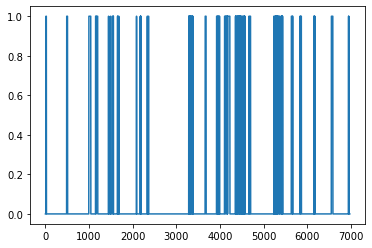

In [42]:
qoi_df_pred['Ssde'].plot()

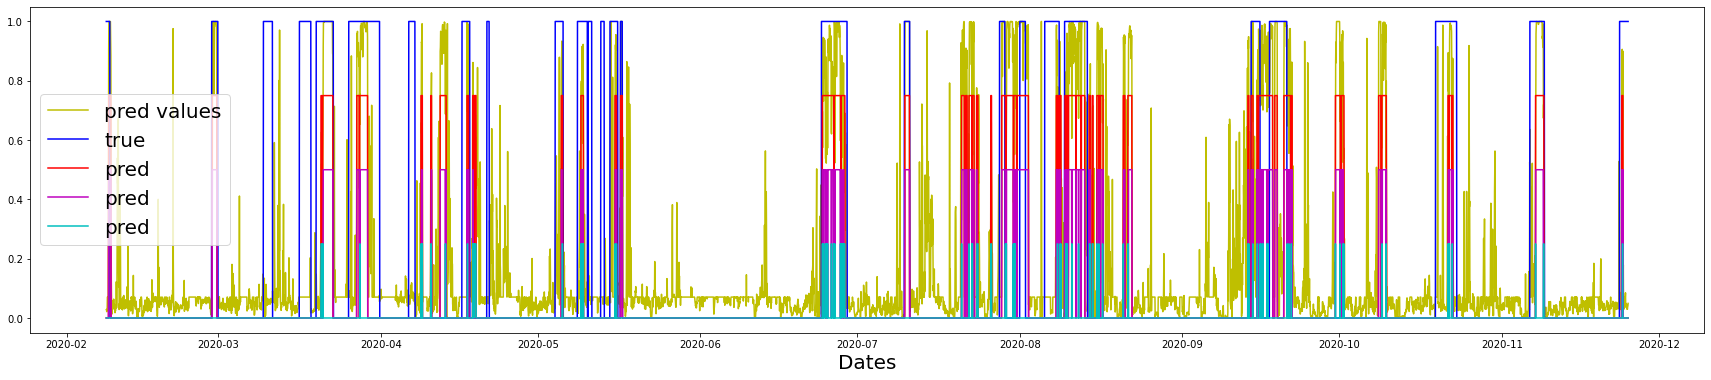

In [43]:
 # PLOT THE PREDICTIONS

plt.figure(figsize = (30,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],df_output['sde_event'],'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.75),'r', label = 'pred')
plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['Ssde']*0.5),'m', label = 'pred')
plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['wsde']*0.25),'c', label = 'pred')

plt.xlabel('Dates', fontsize = 20)
plt.legend(fontsize = 20)



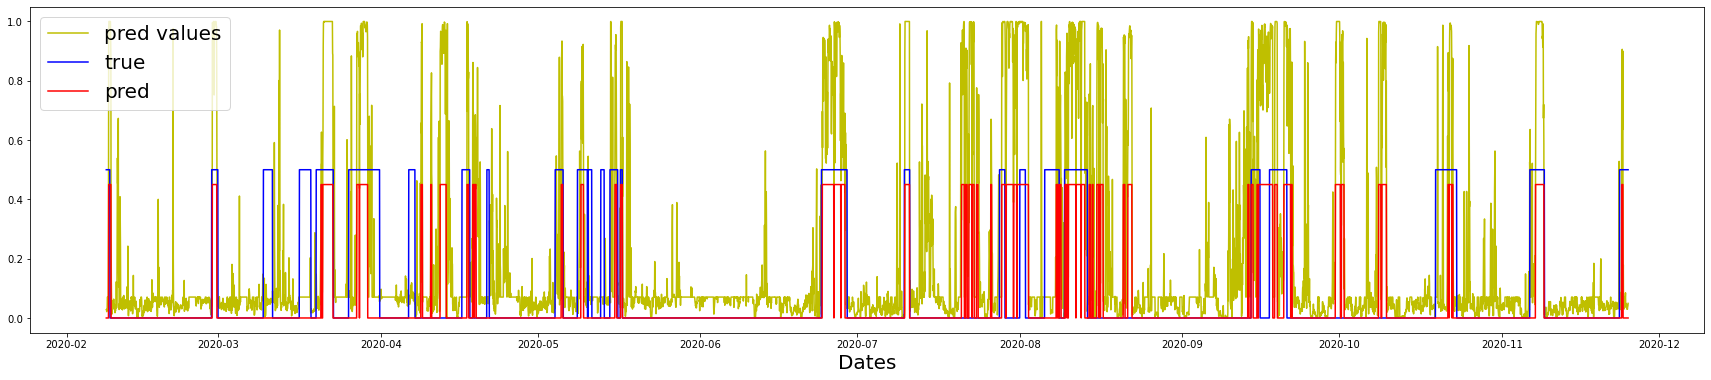

In [44]:
 # PLOT THE PREDICTIONS

plt.figure(figsize = (30,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred')

plt.xlabel('Dates', fontsize = 20)
plt.legend(fontsize = 20)



Text(0, 0.5, 'training_history')

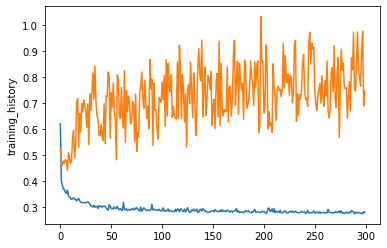

In [45]:
plt.figure()
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.ylabel('training_history')

Text(0, 0.5, 'training_history')

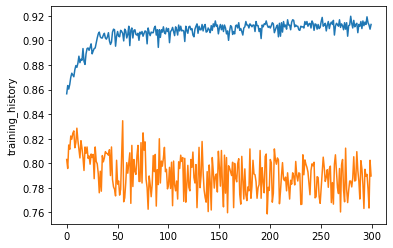

In [46]:
    plt.figure()
    plt.plot(history1['accuracy'])
    plt.plot(history1['val_accuracy'])
    plt.ylabel('training_history')

In [47]:
history1

{'loss': [0.6209626177241191,
  0.4014940317097247,
  0.38346535074599136,
  0.36861450887537794,
  0.36856918018807594,
  0.35615289058874894,
  0.3526395182521333,
  0.3647022198281274,
  0.3438921089376229,
  0.3388256792892319,
  0.33362993706701033,
  0.32918663809374005,
  0.33202144147922236,
  0.33620438525086094,
  0.33004890981815077,
  0.33006991368965055,
  0.32443031104413034,
  0.32873855070863794,
  0.33356045018201963,
  0.32395770772822374,
  0.31993757455481386,
  0.3167942156000516,
  0.3173838926594343,
  0.31712793958180474,
  0.3164238121313948,
  0.3160561534819349,
  0.3199022753949052,
  0.32003017466684214,
  0.3179814461135454,
  0.3101788052442859,
  0.30599302455510696,
  0.3016826624904077,
  0.3003421932463646,
  0.30731581686280246,
  0.29954618284313655,
  0.3028220744636855,
  0.30189000426282336,
  0.294428463127861,
  0.30619876053969747,
  0.301868464732303,
  0.3036809172794003,
  0.299395167381729,
  0.30329037829212396,
  0.30368107122050364,
  0

In [48]:
df_results.columns

Index(['val_0', 'train_0', 'df_0', 'val_1', 'train_1', 'df_1', 'val_2',
       'train_2', 'df_2', 'val_3', 'train_3', 'df_3'],
      dtype='object')

In [49]:
val_col = [x for x in df_results.columns if 'val' in x]
train_col = [x for x in df_results.columns if 'train' in x]
df_col = [x for x in df_results.columns if 'df' in x]
val_col

['val_0', 'val_1', 'val_2', 'val_3']

In [50]:
df_results

val_0    train_0       df_0      val_1    train_1       df_1  \
#sde_truth      5.0  21.000000  26.000000   5.000000  21.000000  26.000000   
#nosde_truth    5.0  21.000000  25.000000   6.000000  20.000000  25.000000   
#sde_pred       9.0  23.000000  32.000000  11.000000  19.000000  30.000000   
#nosde_pred    10.0  24.000000  33.000000  12.000000  20.000000  31.000000   
TP              4.0  13.000000  17.000000   4.000000  13.000000  17.000000   
FN              1.0   8.000000   9.000000   1.000000   8.000000   9.000000   
TN              4.0  17.000000  20.000000   4.000000  17.000000  20.000000   
FP              1.0   4.000000   5.000000   2.000000   3.000000   5.000000   
accuracy        0.8   0.714286   0.725490   0.727273   0.731707   0.725490   
precision       0.8   0.764706   0.772727   0.666667   0.812500   0.772727   
recall          0.8   0.619048   0.653846   0.800000   0.619048   0.653846   
specificity     0.8   0.809524   0.800000   0.666667   0.850000   0.800000   
F1              0.8   0.684211   0.708333   0.727273   0.702703   0.708333   

                 val_2    train_2       df_2   val_3    train_3       df_3  
#sde_truth    8.000000  18.000000  26.000000   8.000  18.000000  26.000000  
#nosde_truth  9.000000  17.000000  25.000000   8.000  18.000000  25.000000  
#sde_pred     4.000000  24.000000  28.000000  12.000  49.000000  61.000000  
#nosde_pred   5.000000  25.000000  29.000000  13.000  50.000000  62.000000  
TP            3.000000  11.000000  14.000000   5.000  15.000000  20.000000  
FN            5.000000   7.000000  12.000000   3.000   3.000000   6.000000  
TN            9.000000  14.000000  22.000000   5.000  11.000000  15.000000  
FP            0.000000   3.000000   3.000000   3.000   7.000000  10.000000  
accuracy      0.705882   0.714286   0.705882   0.625   0.722222   0.686275  
precision     1.000000   0.785714   0.823529   0.625   0.681818   0.666667  
recall        0.375000   0.611111   0.538462   0.625   0.833333   0.769231  
specificity   1.000000   0.823529   0.880000   0.625   0.611111   0.600000  
F1            0.545455   0.687500   0.651163   0.625   0.750000   0.714286

In [51]:
df_results['average_val']=df_results[val_col].mean(axis =1)
df_results['average_train']=df_results[train_col].mean(axis =1)
df_results['average_df']=df_results[df_col].mean(axis =1)



In [52]:
df_results['std_val']=df_results[val_col].std(axis =1)
df_results['std_train']=df_results[train_col].std(axis =1)
df_results['std_df']=df_results[df_col].std(axis =1)



In [53]:
df_results

val_0    train_0       df_0      val_1    train_1       df_1  \
#sde_truth      5.0  21.000000  26.000000   5.000000  21.000000  26.000000   
#nosde_truth    5.0  21.000000  25.000000   6.000000  20.000000  25.000000   
#sde_pred       9.0  23.000000  32.000000  11.000000  19.000000  30.000000   
#nosde_pred    10.0  24.000000  33.000000  12.000000  20.000000  31.000000   
TP              4.0  13.000000  17.000000   4.000000  13.000000  17.000000   
FN              1.0   8.000000   9.000000   1.000000   8.000000   9.000000   
TN              4.0  17.000000  20.000000   4.000000  17.000000  20.000000   
FP              1.0   4.000000   5.000000   2.000000   3.000000   5.000000   
accuracy        0.8   0.714286   0.725490   0.727273   0.731707   0.725490   
precision       0.8   0.764706   0.772727   0.666667   0.812500   0.772727   
recall          0.8   0.619048   0.653846   0.800000   0.619048   0.653846   
specificity     0.8   0.809524   0.800000   0.666667   0.850000   0.800000   
F1              0.8   0.684211   0.708333   0.727273   0.702703   0.708333   

                 val_2    train_2       df_2   val_3    train_3       df_3  \
#sde_truth    8.000000  18.000000  26.000000   8.000  18.000000  26.000000   
#nosde_truth  9.000000  17.000000  25.000000   8.000  18.000000  25.000000   
#sde_pred     4.000000  24.000000  28.000000  12.000  49.000000  61.000000   
#nosde_pred   5.000000  25.000000  29.000000  13.000  50.000000  62.000000   
TP            3.000000  11.000000  14.000000   5.000  15.000000  20.000000   
FN            5.000000   7.000000  12.000000   3.000   3.000000   6.000000   
TN            9.000000  14.000000  22.000000   5.000  11.000000  15.000000   
FP            0.000000   3.000000   3.000000   3.000   7.000000  10.000000   
accuracy      0.705882   0.714286   0.705882   0.625   0.722222   0.686275   
precision     1.000000   0.785714   0.823529   0.625   0.681818   0.666667   
recall        0.375000   0.611111   0.538462   0.625   0.833333   0.769231   
specificity   1.000000   0.823529   0.880000   0.625   0.611111   0.600000   
F1            0.545455   0.687500   0.651163   0.625   0.750000   0.714286   

              average_val  average_train  average_df   std_val  std_train  \
#sde_truth       6.500000      19.500000   26.000000  1.732051   1.732051   
#nosde_truth     7.000000      19.000000   25.000000  1.825742   1.825742   
#sde_pred        9.000000      28.750000   37.750000  3.559026  13.671747   
#nosde_pred     10.000000      29.750000   38.750000  3.559026  13.671747   
TP               4.000000      13.000000   17.000000  0.816497   1.632993   
FN               2.500000       6.500000    9.000000  1.914854   2.380476   
TN               5.500000      14.750000   19.250000  2.380476   2.872281   
FP               1.500000       4.250000    5.750000  1.290994   1.892969   
accuracy         0.714539       0.720625    0.710784  0.072014   0.008281   
precision        0.772917       0.761185    0.758913  0.168789   0.056410   
recall           0.650000       0.670635    0.653846  0.201039   0.108530   
specificity      0.772917       0.773541    0.770000  0.168789   0.109580   
F1               0.674432       0.706103    0.695529  0.112009   0.030353   

                 std_df  
#sde_truth     0.000000  
#nosde_truth   0.000000  
#sde_pred     15.585784  
#nosde_pred   15.585784  
TP             2.449490  
FN             2.449490  
TN             2.986079  
FP             2.986079  
accuracy       0.018773  
precision      0.065996  
recall         0.094211  
specificity    0.119443  
F1             0.029710

In [54]:
df_results[df_col]

df_0       df_1       df_2       df_3
#sde_truth    26.000000  26.000000  26.000000  26.000000
#nosde_truth  25.000000  25.000000  25.000000  25.000000
#sde_pred     32.000000  30.000000  28.000000  61.000000
#nosde_pred   33.000000  31.000000  29.000000  62.000000
TP            17.000000  17.000000  14.000000  20.000000
FN             9.000000   9.000000  12.000000   6.000000
TN            20.000000  20.000000  22.000000  15.000000
FP             5.000000   5.000000   3.000000  10.000000
accuracy       0.725490   0.725490   0.705882   0.686275
precision      0.772727   0.772727   0.823529   0.666667
recall         0.653846   0.653846   0.538462   0.769231
specificity    0.800000   0.800000   0.880000   0.600000
F1             0.708333   0.708333   0.651163   0.714286

In [55]:
df_results[val_col].loc['accuracy']

val_0    0.800000
val_1    0.727273
val_2    0.705882
val_3    0.625000
Name: accuracy, dtype: float64

In [56]:
df_results[val_col].loc['accuracy']

val_0    0.800000
val_1    0.727273
val_2    0.705882
val_3    0.625000
Name: accuracy, dtype: float64

In [57]:
df_results.to_hdf(f'{modelpath}/df_results.h5', key = 'results')

In [58]:
surr1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 24)                600       
                                                                 
 gaussian_noise (GaussianNoi  (None, 24)               0         
 se)                                                             
                                                                 
 dense_6 (Dense)             (None, 75)                1875      
                                                                 
 dense_7 (Dense)             (None, 75)                5700      
                                                                 
 dense_8 (Dense)             (None, 1)                 76        
                                                                 
Total params: 8,251
Trainable params: 8,251
Non-trainable params: 0
____________________________________________________

In [59]:

datafile = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/data/data.h5'

modelpath0 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model0'
modelpath1 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model1'
modelpath2 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model2'
modelpath3 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model3'
modelpath4 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model4'
modelpath5 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model5'
modelpath6 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model6'
modelpath7 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model7'
modelpath8 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model8'
modelpath9 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model9'








df = pd.read_hdf(datafile, 'df') 
df_output = df['sde_event']
df_output = pd.DataFrame(data = df_output, columns = ['sde_event'])
df_dates = df[['DateTimeUTC','sde_event','sde_event_nr']]
df_input = df.drop(['sde_event_nr','sde_event','DateTimeUTC'],axis =1)

df_input.reset_index(drop=True, inplace=True)

df_output.reset_index(drop=True, inplace=True)

df_dates.reset_index(drop=True, inplace=True)

surr0 = keras.models.load_model(modelpath0)
surr1 = keras.models.load_model(modelpath1)    
surr2 = keras.models.load_model(modelpath2)    
surr3 = keras.models.load_model(modelpath3)    
surr4 = keras.models.load_model(modelpath4)
surr5 = keras.models.load_model(modelpath5)
surr6 = keras.models.load_model(modelpath6) 
surr7 = keras.models.load_model(modelpath7)
surr8 = keras.models.load_model(modelpath8)   
surr9 = keras.models.load_model(modelpath9) 
# APPLY PREPROCESSING

qoi_min = np.min(qoi_train, axis = 0)
qoi_max = np.max(qoi_train, axis = 0)
dvar_min = np.min(dvar_train, axis = 0)
dvar_max = np.max(dvar_train, axis = 0)
dvar_df_scaled = scaling(df_input, dvar_min, dvar_max, scale_min, scale_max)

# USE TRAINED NETWORKS FOR PREDICTION
qoi_df_pred0 = surr0.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
qoi_df_pred1 = surr1.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred2 = surr2.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred3 = surr3.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred4 = surr4.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred5 = surr5.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred6 = surr6.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred7 = surr7.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
qoi_df_pred8 = surr8.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
qoi_df_pred9 = surr9.predict(np.asarray(dvar_df_scaled.values).astype('float32'))




qoi_df_pred_new = (qoi_df_pred0+qoi_df_pred1+qoi_df_pred2+qoi_df_pred3+qoi_df_pred4+qoi_df_pred5+qoi_df_pred6+qoi_df_pred7+qoi_df_pred8+qoi_df_pred9)/10.

#qoi_df_pred_new = (qoi_df_pred0+qoi_df_pred1+qoi_df_pred3+qoi_df_pred4+qoi_df_pred6+qoi_df_pred7+qoi_df_pred8+qoi_df_pred9)/8.



qoi_df_pred_new = pd.DataFrame(qoi_df_pred_new, columns = ['sde_event'])

qoi_df_pred_new = compute_dust_events(qoi_df_pred_new)

df_dates = number_noevents_dates(df_dates, 'sde_event_nr', 'nosde_event_nr')
qoi_df_pred_new = number_noevents_data(qoi_df_pred_new, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

'''
qoi_df_pred0 = pd.DataFrame(qoi_df_pred0, columns = ['sde_event'])
qoi_df_pred0 = compute_dust_events(qoi_df_pred0)
qoi_df_pred0 = number_noevents_data(qoi_df_pred0, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred1 = pd.DataFrame(qoi_df_pred1, columns = ['sde_event'])
qoi_df_pred1 = compute_dust_events(qoi_df_pred1)
qoi_df_pred1 = number_noevents_data(qoi_df_pred1, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred2 = pd.DataFrame(qoi_df_pred2, columns = ['sde_event'])
qoi_df_pred2 = compute_dust_events(qoi_df_pred2)
qoi_df_pred2 = number_noevents_data(qoi_df_pred2, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred3 = pd.DataFrame(qoi_df_pred3, columns = ['sde_event'])
qoi_df_pred3 = compute_dust_events(qoi_df_pred3)
qoi_df_pred3 = number_noevents_data(qoi_df_pred3, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred4 = pd.DataFrame(qoi_df_pred4, columns = ['sde_event'])
qoi_df_pred4 = compute_dust_events(qoi_df_pred4)
qoi_df_pred4 = number_noevents_data(qoi_df_pred4, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred5 = pd.DataFrame(qoi_df_pred5, columns = ['sde_event'])
qoi_df_pred5 = compute_dust_events(qoi_df_pred5)
qoi_df_pred5 = number_noevents_data(qoi_df_pred5, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred6 = pd.DataFrame(qoi_df_pred6, columns = ['sde_event'])
qoi_df_pred6 = compute_dust_events(qoi_df_pred6)
qoi_df_pred6 = number_noevents_data(qoi_df_pred6, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred7 = pd.DataFrame(qoi_df_pred7, columns = ['sde_event'])
qoi_df_pred7 = compute_dust_events(qoi_df_pred7)
qoi_df_pred7 = number_noevents_data(qoi_df_pred7, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred8 = pd.DataFrame(qoi_df_pred8, columns = ['sde_event'])
qoi_df_pred8 = compute_dust_events(qoi_df_pred8)
qoi_df_pred8 = number_noevents_data(qoi_df_pred8, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred9 = pd.DataFrame(qoi_df_pred9, columns = ['sde_event'])
qoi_df_pred9 = compute_dust_events(qoi_df_pred9)
qoi_df_pred9 = number_noevents_data(qoi_df_pred9, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')


qoi_df_pred_new_test = qoi_df_pred_new.copy()
qoi_df_pred_new = (qoi_df_pred0+qoi_df_pred1+qoi_df_pred2+qoi_df_pred3+qoi_df_pred4+qoi_df_pred5+qoi_df_pred6+qoi_df_pred7+qoi_df_pred8+qoi_df_pred9)/10.
'''




print('Whole dataframe')
result_df_new = metric_sde(df_dates, qoi_df_pred_new)
result_df_acc_new = acc_prec_rec(result_df_new[4],result_df_new[5], result_df_new[6], result_df_new[7])

df_result_new = np.concatenate((result_df_new,np.array(result_df_acc_new[0:5])), axis =0)

df_results['df_total'] = df_result_new
df_results.rename(index = rowdict, inplace=True)
df_results    





# PLOT THE PREDICTIONS

plt.figure(figsize = (40,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred_new['sde_event'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred_new['sde_event_predicted']*0.45),'r', label = 'pred')
plt.title('training')
plt.xlabel('Dates')
plt.legend()




FileNotFoundError: File /Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/data/data.h5 does not exist

In [60]:
#(qoi_df_pred_new['sde_event']-qoi_df_pred_new_test['sde_event']).sum()

In [ ]:


for index in [1]:
    
    print('Model: ', index)

    
    datafile_train = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_24_11_2022/train'+str(index)+'.h5'
   
    datafile_val = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_24_11_2022/val'+str(index)+'.h5'

    datafile = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_24_11_2022/data_all.h5'


    modelpath = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_24_11_2022/model_'+str(index)


    
    
    df = pd.read_hdf(datafile, 'df') 
    df_output = df['sde_event']
    df_output = pd.DataFrame(data = df_output, columns = ['sde_event'])
    df_dates = df[['DateTimeUTC','sde_event','sde_event_nr']]
    df_input = df.drop(['sde_event_nr','sde_event','DateTimeUTC'],axis =1)

    df_input.reset_index(drop=True, inplace=True)

    df_output.reset_index(drop=True, inplace=True)

    df_dates.reset_index(drop=True, inplace=True)
    
    dvar_train = pd.read_hdf(datafile_train,key = 'dvar')
    dvar_val = pd.read_hdf(datafile_val,key = 'dvar')
    qoi_train = pd.read_hdf(datafile_train,key = 'qoi')
    qoi_val = pd.read_hdf(datafile_val,key = 'qoi')
    dates_train = pd.read_hdf(datafile_train,key = 'dates')
    dates_val = pd.read_hdf(datafile_val,key = 'dates')    
    history1=np.load(modelpath+'/my_history.npy',allow_pickle='TRUE').item()
    surr1 = keras.models.load_model(modelpath)
    # APPLY PREPROCESSING

    qoi_min = np.min(qoi_train, axis = 0)
    qoi_max = np.max(qoi_train, axis = 0)
    dvar_min = np.min(dvar_train, axis = 0)
    dvar_max = np.max(dvar_train, axis = 0)
    dvar_train_scaled = scaling(dvar_train, dvar_min, dvar_max, scale_min, scale_max)
    dvar_val_scaled = scaling(dvar_val, dvar_min, dvar_max, scale_min, scale_max)
    dvar_df_scaled = scaling(df_input, dvar_min, dvar_max, scale_min, scale_max)
    
    # USE TRAINED NETWORKS FOR PREDICTION
    qoi_val_pred = surr1.predict(np.asarray(dvar_val_scaled.values).astype('float32'))
    qoi_train_pred = surr1.predict(np.asarray(dvar_train_scaled.values).astype('float32'))
    qoi_df_pred = surr1.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
    
    qoi_val_pred = pd.DataFrame(qoi_val_pred, columns = ['sde_event'])
    qoi_train_pred = pd.DataFrame(qoi_train_pred, columns = ['sde_event'])
    
    qoi_df_pred = pd.DataFrame(qoi_df_pred, columns = ['sde_event'])
   
    qoi_train_pred = compute_dust_events(qoi_train_pred)
    qoi_val_pred = compute_dust_events(qoi_val_pred)
    qoi_df_pred = compute_dust_events(qoi_df_pred)
    
    dates_val = number_noevents_dates(dates_val, 'sde_event_nr', 'nosde_event_nr')
    dates_train = number_noevents_dates(dates_train, 'sde_event_nr', 'nosde_event_nr')
    df_dates = number_noevents_dates(df_dates, 'sde_event_nr', 'nosde_event_nr')
    qoi_val_pred = number_noevents_data(qoi_val_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')
    qoi_train_pred = number_noevents_data(qoi_train_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')
    qoi_df_pred = number_noevents_data(qoi_df_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

    
    
    print('Validation')
    result_val = metric_sde(dates_val, qoi_val_pred)
    print(result_val)
    result_val_acc = acc_prec_rec(result_val[4],result_val[5], result_val[6], result_val[7])
    
    print('Training')
    result_train = metric_sde(dates_train, qoi_train_pred)
    result_train_acc = acc_prec_rec(result_train[4],result_train[5], result_train[6], result_train[7])

    print('Whole dataframe')
    result_df = metric_sde(df_dates, qoi_df_pred)
    result_df_acc = acc_prec_rec(result_df[4],result_df[5], result_df[6], result_df[7])
    
    val_result = np.concatenate((result_val,np.array(result_val_acc[0:5])), axis =0)
    train_result = np.concatenate((result_train,np.array(result_train_acc[0:5])), axis =0)
    df_result = np.concatenate((result_df,np.array(result_df_acc[0:5])), axis =0)

    df_results['val_'+str(index)]= val_result
    df_results['train_'+str(index)] = train_result
    df_results['df_'+str(index)] = df_result
    df_results.rename(index = rowdict, inplace=True)
    df_results    
    
    
    
    
    
    # PLOT THE PREDICTIONS
    plt.figure(figsize = (40,6))
    plt.plot(dates_val['Dates'],qoi_val_pred['sde_event'],'y',label='pred values')
    plt.plot(dates_val['Dates'],qoi_val['sde_event']*0.5,'b',label = 'true')

    plt.plot(dates_val['Dates'],(qoi_val_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.xlabel('Dates')
    plt.title('validation')
    plt.legend()

    plt.figure(figsize = (40,6))
    plt.plot(dates_train['Dates'],qoi_train_pred['sde_event'],'y',label='pred values')
    plt.plot(dates_train['Dates'],qoi_train['sde_event']*0.5,'b',label = 'true')

    plt.plot(dates_train['Dates'],(qoi_train_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.title('training')
    plt.xlabel('Dates') 
    plt.legend()
    
    plt.figure(figsize = (40,6))
    plt.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred values')
    plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

    plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.title('training')
    plt.xlabel('Dates')
    plt.legend()
    
    
    plt.figure()
    plt.plot(history1['loss'])
    plt.plot(history1['val_loss'])
    plt.ylabel('training_history')
    
    plt.figure()
    plt.plot(history1['accuracy'])
    plt.plot(history1['val_accuracy'])
    plt.ylabel('training_history_Accuracy')

In [ ]:
fig, ax = plt.subplots(figsize = (20,6))
ax.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred. values')
ax.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.75,'b',label = 'true SDE')

ax.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred. SDE')

plt.xlabel('Dates', fontsize = 20)
plt.legend(fontsize = 20, loc ='lower left')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=5)


In [ ]:
fig, ax = plt.subplots(figsize = (20,6))
ax.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred. values')
ax.plot(df_dates['DateTimeUTC'],df_output['sde_event'],'b',label = 'true SDE')

#ax.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred. SDE')

plt.xlabel('Dates', fontsize = 20)
plt.ylabel('Probability of event occurrence', fontsize = 20)
plt.legend(fontsize = 20, loc ='lower left')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=5)


In [ ]:
df_results[val_col]

In [ ]:
df_results[train_col]

In [ ]:
df_results[df_col]

In [ ]:
surr0.summary()

In [ ]:
surr1.summary()

In [ ]:
surr2.summary()

In [ ]:
surr3.summary()

In [ ]:
surr4.summary()

In [ ]:
surr5.summary()

In [ ]:
surr6.summary()

In [ ]:
surr7.summary()

In [ ]:
surr8.summary()

In [ ]:
surr9.summary()

In [ ]:
df_results[['df_total']]

In [ ]:
df_results

In [ ]:
df_col1 = [x for x in df_results.columns if 'df' in x]
val_col1 = [x for x in df_results.columns if 'val' in x]
train_col1 = [x for x in df_results.columns if 'train' in x]

In [ ]:
df_results[df_col1]

In [ ]:
df_results[val_col1]

In [ ]:
df_results[train_col1]

In [ ]:

qoi_df_pred0 = pd.DataFrame(qoi_df_pred0, columns = ['sde_event'])
qoi_df_pred0 = compute_dust_events(qoi_df_pred0)
qoi_df_pred0 = number_noevents_data(qoi_df_pred0, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred1 = pd.DataFrame(qoi_df_pred1, columns = ['sde_event'])
qoi_df_pred1 = compute_dust_events(qoi_df_pred1)
qoi_df_pred1 = number_noevents_data(qoi_df_pred1, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred2 = pd.DataFrame(qoi_df_pred2, columns = ['sde_event'])
qoi_df_pred2 = compute_dust_events(qoi_df_pred2)
qoi_df_pred2 = number_noevents_data(qoi_df_pred2, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred3 = pd.DataFrame(qoi_df_pred3, columns = ['sde_event'])
qoi_df_pred3 = compute_dust_events(qoi_df_pred3)
qoi_df_pred3 = number_noevents_data(qoi_df_pred3, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred4 = pd.DataFrame(qoi_df_pred4, columns = ['sde_event'])
qoi_df_pred4 = compute_dust_events(qoi_df_pred4)
qoi_df_pred4 = number_noevents_data(qoi_df_pred4, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred5 = pd.DataFrame(qoi_df_pred5, columns = ['sde_event'])
qoi_df_pred5 = compute_dust_events(qoi_df_pred5)
qoi_df_pred5 = number_noevents_data(qoi_df_pred5, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred6 = pd.DataFrame(qoi_df_pred6, columns = ['sde_event'])
qoi_df_pred6 = compute_dust_events(qoi_df_pred6)
qoi_df_pred6 = number_noevents_data(qoi_df_pred6, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred7 = pd.DataFrame(qoi_df_pred7, columns = ['sde_event'])
qoi_df_pred7 = compute_dust_events(qoi_df_pred7)
qoi_df_pred7 = number_noevents_data(qoi_df_pred7, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred8 = pd.DataFrame(qoi_df_pred8, columns = ['sde_event'])
qoi_df_pred8 = compute_dust_events(qoi_df_pred8)
qoi_df_pred8 = number_noevents_data(qoi_df_pred8, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred9 = pd.DataFrame(qoi_df_pred9, columns = ['sde_event'])
qoi_df_pred9 = compute_dust_events(qoi_df_pred9)
qoi_df_pred9 = number_noevents_data(qoi_df_pred9, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')


qoi_df_pred_new_test = qoi_df_pred_new.copy()
qoi_df_pred_new_test2 = (qoi_df_pred0+qoi_df_pred1+qoi_df_pred2+qoi_df_pred3+qoi_df_pred4+qoi_df_pred5+qoi_df_pred6+qoi_df_pred7+qoi_df_pred8+qoi_df_pred9)/10.




In [ ]:
qoi_df_pred_new_test2

In [ ]:
print('Whole dataframe')
result_df_new_test2 = metric_sde(df_dates, qoi_df_pred_new_test2)
result_df_acc_new_test2 = acc_prec_rec(result_df_new_test2[4],result_df_new_test2[5], result_df_new_test2[6], result_df_new_test2[7])

df_result_new_test2 = np.concatenate((result_df_new_test2,np.array(result_df_acc_new_test2[0:5])), axis =0)

df_results['df_total'] = df_result_new_test2
#df_results.rename(index = rowdict, inplace=True)
df_results    





# PLOT THE PREDICTIONS

plt.figure(figsize = (40,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred_new['sde_event'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred_new['sde_event_predicted']*0.45),'r', label = 'pred')
plt.title('training')
plt.xlabel('Dates')
plt.legend()





In [ ]:
qoi_df_pred0

In [ ]:
# PLOT THE PREDICTIONS

plt.figure(figsize = (40,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred0['sde_event_predicted'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred1['sde_event_predicted']*0.75,'g',label='pred values')

plt.plot(df_dates['DateTimeUTC'],qoi_df_pred_new['sde_event_predicted']*1.25,'m',label='pred values')

plt.plot(df_dates['DateTimeUTC'],qoi_df_pred_new_test2['sde_event_predicted']*1.35,'k',label='pred values')


plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*1.5,'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred2['sde_event_predicted']*0.5),'r', label = 'pred')
plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred3['sde_event_predicted']*0.25),'k', label = 'pred')


plt.title('training')
plt.xlabel('Dates')
plt.legend()




